# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**:
* **Instructor name**: Jeff Herman
* **Blog post URL**:
* **Notebook**: 3/

# Introduction

The purpose of this project is to do a thorough exploratory data analysis of the characters and scripts of the TV show How I Met Your Mother, as well as create a model that can predict who said which line. The data is from the website https://transcripts.foreverdreaming.org/viewforum.php?f=177 where there are nine pages containing the 208 episodes from nine seasons that the show ran.

This is the third notebook for my Capstone Project. This notebook contains the exploratory data analysis of the data set. There were numerous ways to explore this data, and they are detailed below.

## Import Libraries

In the following cell I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import matplotlib.font_manager
import ast
import matplotlib.image as mpimg
import re
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from nltk import FreqDist
from wordcloud import WordCloud
from PIL import Image
from nltk.collocations import *

## Load Data

Next we load in the data set we saved in the previous notebook, it has a column with calculated sentiment score and a column with the motions the characters made (if any). Then we'll pull in the database created on my desktop and start exploring SQL queries.

In [2]:
df = pd.read_csv('DFforSQL.csv') #Reading in dataset
df.head() #Checking first five rows

Season  Episode Character  \
0       1        1  Marshall   
1       1        1       Ted   
2       1        1  Marshall   
3       1        1       Ted   
4       1        1  Marshall   

                                                Line            Motion  \
0                                 Will you marry me.  ['(Opens ring)']   
1  Yes, perfect! And then you're engaged, you pop...                []   
2  Got it. Thanks for helping me plan this out, Ted.                []   
3  Dude, are you kidding? It's you and Lily! I've...                []   
4           yeah, sorry. We thought you were asleep.      ['(laughs)']   

   Polarity  Subjectivity  
0   0.00000      0.000000  
1   1.00000      1.000000  
2   0.20000      0.200000  
3   0.09375      0.285417  
4  -0.50000      1.000000

Real quick, we're going to convert the motion list from a list of strings as a string to just of list of strings so we can get rid of those pesky apostrophies.

In [3]:
df['Motion'] = df['Motion'].map(ast.literal_eval) #converting list of strings as string to list of strings

df.head() #checking df

Season  Episode Character  \
0       1        1  Marshall   
1       1        1       Ted   
2       1        1  Marshall   
3       1        1       Ted   
4       1        1  Marshall   

                                                Line          Motion  \
0                                 Will you marry me.  [(Opens ring)]   
1  Yes, perfect! And then you're engaged, you pop...              []   
2  Got it. Thanks for helping me plan this out, Ted.              []   
3  Dude, are you kidding? It's you and Lily! I've...              []   
4           yeah, sorry. We thought you were asleep.      [(laughs)]   

   Polarity  Subjectivity  
0   0.00000      0.000000  
1   1.00000      1.000000  
2   0.20000      0.200000  
3   0.09375      0.285417  
4  -0.50000      1.000000

Great! Now it's time to create a connection to our SQL database, then it's time to begin exploring!

In [4]:
df = df.applymap(str) #Convert df to str so it will transition to SQL smoother
conn = sqlite3.connect('HIMYM.db') #Connect to the db
df.to_sql('DFforSQL', conn, if_exists = 'replace', index = False) #Save into DFforSQL table

# Exploratory Data Analysis

There are lots of different things I want to explore: number of lines per character throughout the series and throughout the seasons, which characters were mentioned the most by other characters, which characters spoke about sex, drinking, and marriage the most, who used the most words, who has the most positive vs negative sentiment, etc. These explorations don't even involve specifically looking into each character's vocabulary; most used terms, most used phrases, etc. 

Before we start looking at specifics, let's take a look at the spread of the data, we know that season 9 wasn't transcribed properly so we have no scripts to use from that season; it's likely that other seasons weren't transcribed properly either. Let's see how everything looks before we dive deep into everything so we have a better understanding for some of these numbers.

Again, there is a lot to explore here, but this will inform what we want to model and predict so let's get started!


## Number of Lines per Season

First I want to see the total number of lines scraped for each season. I know already that this dataset contains over 4 1/2 million rows of data (aka, 4 1/2 million lines) but how is that spread across the seasons? Is it even?

In [5]:
q0 = pd.read_sql("""
SELECT Season, Count(Line) AS 'Season_Lines'
FROM DFforSQL
GROUP BY Season
ORDER BY Season
;
""", conn)

q0

Season  Season_Lines
0      1          4282
1      2          3249
2      3          2609
3      4          4025
4      5          4145
5      6          3685
6      7           443
7      8            37

Seasons 1-6 are all about the same, give or take a couple hundred (I wonder where those discrepancies are coming from). However, seasons 7 and 8 are both significantly smaller, with 7 having less than 1000 and 8 having less than 100. As important as those seasons are for character arcs and storylines, it will be beneficial to remove those seasons from this analysis when it comes time to model, as this large difference could cause issues depending on what we try to predict.

In [6]:
import matplotlib.font_manager as font_manager

plt.style.use('seaborn')

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

font_dir = ['/Users/robotrobz/Downloads/Dax Regular']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
rcParams['font.family'] = 'Dax'

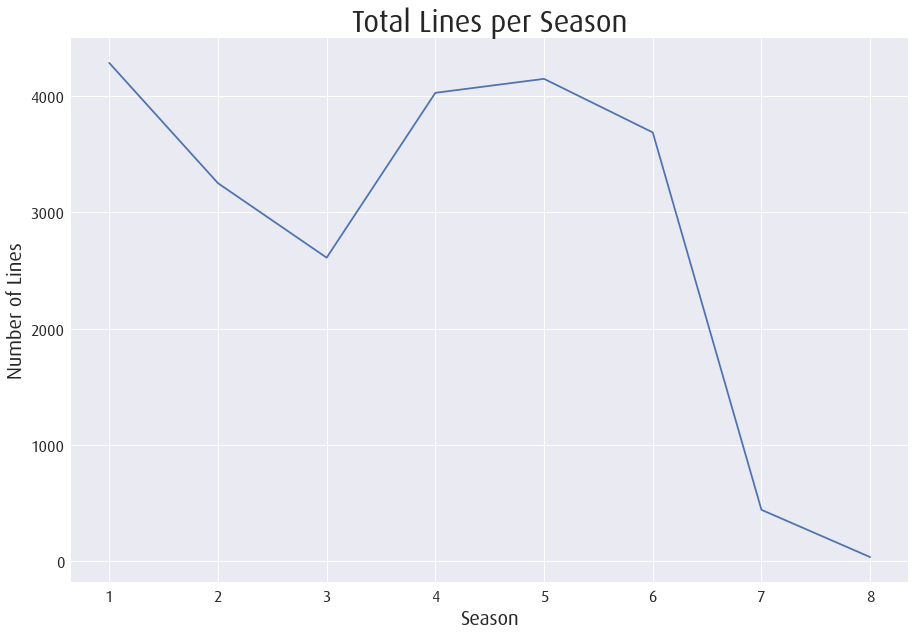

In [7]:
plt.figure(figsize = (15, 10)) #Set figure size
plt.plot(q0['Season'], q0['Season_Lines'], label = 'Total') #Setting plot
plt.title('Total Lines per Season', size = 30) #Set title of graph
plt.xlabel('Season', size = 20) #Set x label
plt.xticks(fontsize = 16) #Set tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16) #Set tick size
plt.show() #Show graph

## Lines During Series

The following query explores the number of lines per character throughout the entires series.

In [8]:
q1 = pd.read_sql("""
SELECT Character, Count(Line) AS 'Spoken_Lines'
FROM DFforSQL
GROUP BY Character
ORDER BY Spoken_Lines DESC
;
""", conn)

q1

Character  Spoken_Lines
0       Ted          6058
1    Barney          4722
2  Marshall          4309
3     Robin          3806
4      Lily          3580

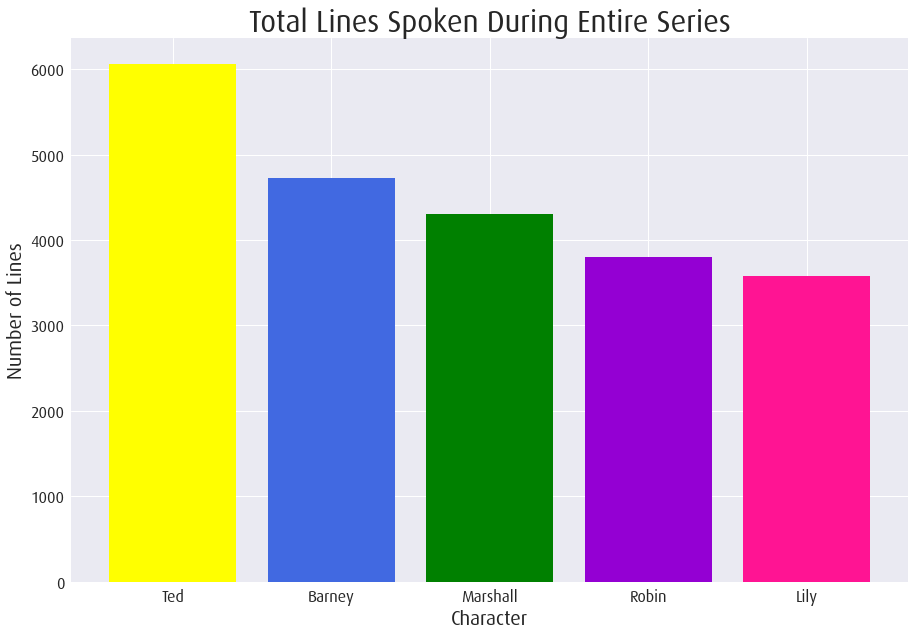

In [9]:
plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'green', 'darkviolet', 'deeppink'] #Setting bar colors
plt.bar(q1['Character'], q1['Spoken_Lines'], color = c) #Set colors for bars
plt.title('Total Lines Spoken During Entire Series', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

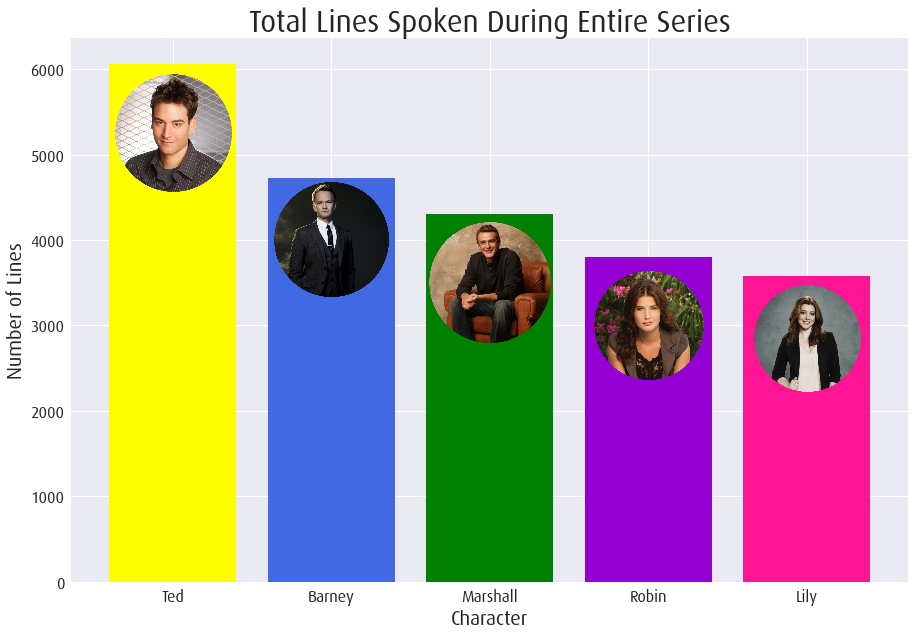

In [10]:
plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'green', 'darkviolet', 'deeppink'] #Setting bar colors
plt.bar(range(5), q1['Spoken_Lines'], color = c)
plt.xticks(range(5), q1['Character'])
ax = plt.gca()
# Ted
img = plt.imread('/Users/robotrobz/Documents/Capstone/Capstone/Characters/Ted.png')
im = OffsetImage(img, zoom = .18)
im.image.axes = ax
x_offset = -25
ab = AnnotationBbox(im, (.16, 5250), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0)
ax.add_artist(ab)
# Barney
img = plt.imread('/Users/robotrobz/Documents/Capstone/Capstone/Characters/Barney.png')
im = OffsetImage(img, zoom = .2)
im.image.axes = ax
x_offset = -25
ab = AnnotationBbox(im, (1.16, 4000), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0)
ax.add_artist(ab)
# Marshall
img = plt.imread('/Users/robotrobz/Documents/Capstone/Capstone/Characters/Marshall.png')
im = OffsetImage(img, zoom = .18)
im.image.axes = ax
x_offset = -25
ab = AnnotationBbox(im, (2.16, 3500), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0)
ax.add_artist(ab)
# Robin
img = plt.imread('/Users/robotrobz/Documents/Capstone/Capstone/Characters/Robin.png')
im = OffsetImage(img, zoom = .2)
im.image.axes = ax
x_offset = -25
ab = AnnotationBbox(im, (3.16, 3000), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0)
ax.add_artist(ab)
# Lily
img = plt.imread('/Users/robotrobz/Documents/Capstone/Capstone/Characters/Lily.png')
im = OffsetImage(img, zoom = .2)
im.image.axes = ax
x_offset = -25
ab = AnnotationBbox(im, (4.16, 2850), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0)
ax.add_artist(ab)
plt.title('Total Lines Spoken During Entire Series', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show(); #Show graph

## Lines by Season

The following query explores the number of lines per character by each individual season.

In [11]:
q2 = pd.read_sql("""
SELECT Character, Season, COUNT(Line) AS 'Total_Lines'
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
GROUP BY Season, Character
;
""", conn)

q2

Character Season  Total_Lines
0     Barney      1          747
1       Lily      1          733
2   Marshall      1          751
3      Robin      1          658
4        Ted      1         1393
5     Barney      2          621
6       Lily      2          523
7   Marshall      2          607
8      Robin      2          605
9        Ted      2          893
10    Barney      3          674
11      Lily      3          388
12  Marshall      3          435
13     Robin      3          399
14       Ted      3          713
15    Barney      4          938
16      Lily      4          567
17  Marshall      4          788
18     Robin      4          691
19       Ted      4         1041
20    Barney      5          845
21      Lily      5          665
22  Marshall      5          856
23     Robin      5          741
24       Ted      5         1038
25    Barney      6          811
26      Lily      6          631
27  Marshall      6          736
28     Robin      6          633
29       Ted      6          874
30    Barney      7           80
31      Lily      7           68
32  Marshall      7          125
33     Robin      7           76
34       Ted      7           94
35    Barney      8            6
36      Lily      8            5
37  Marshall      8           11
38     Robin      8            3
39       Ted      8           12

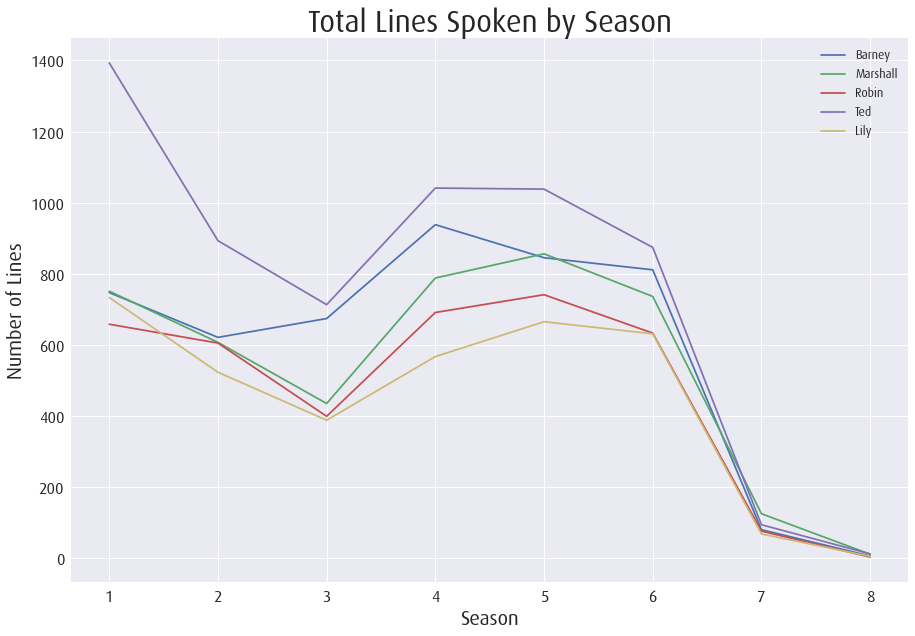

In [12]:
char_set = set(q2['Character']) #Turn individual characters into set

c = ['darkviolet', 'royalblue', 'deeppink', 'yellow', 'green'] #Setting line colors

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = q2.loc[q2['Character'] == character] #Grab characters
    plt.plot(selected_data['Season'], selected_data['Total_Lines'], label = character) #Plot lines
    
    
plt.title('Total Lines Spoken by Season', size = 30) #Set title of graph
plt.xlabel('Season', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'large')
plt.show()

## Most Spoken About

The following query explores which character was spoken about the most by other characters.

In [13]:
nicknames = [['Ted', 'Teddy Westside', 'T-Mose', 'Teddy Bear', 'Galactic President Superstar McAwesomeville'], 
            ['Marshall', 'Marsh ', 'Marshmallow', 'Big Fudge', 'Vanilla Thunder', 'Marsh Madness'], 
            ['Barney', 'The Barnacle'], 
            ['Robin', 'Robin Sparkles', 'RJ', 'Roland'], 
            ['Lily', 'Lilypad', 'Lori']]

In [14]:
all_lines = pd.read_sql("""
SELECT Line
FROM DFforSQL""", conn) #SQL query to get all lines

char_mention = [] #list to hold all character mention totals

for name_list in nicknames: #Loop for each character
    mention_counter = 0 #Keep track of each mention
    for name in name_list: #Loop for each nickname
        mentions = all_lines['Line'].str.count(name).sum()
        mention_counter += mentions
        char_mention.append([name_list[0], mention_counter]) #Append name and mention count

In [15]:
char_mention

[['Ted', 1457],
 ['Ted', 1462],
 ['Ted', 1465],
 ['Ted', 1467],
 ['Ted', 1468],
 ['Marshall', 888],
 ['Marshall', 889],
 ['Marshall', 898],
 ['Marshall', 901],
 ['Marshall', 902],
 ['Marshall', 903],
 ['Barney', 962],
 ['Barney', 964],
 ['Robin', 868],
 ['Robin', 871],
 ['Robin', 872],
 ['Robin', 873],
 ['Lily', 909],
 ['Lily', 916],
 ['Lily', 921]]

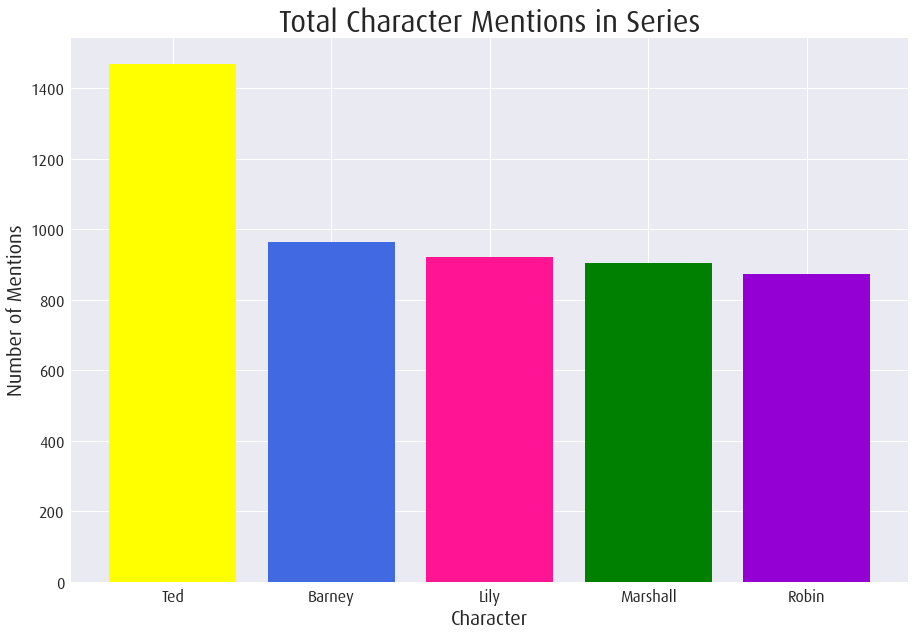

In [16]:
chars = ['Ted', 'Barney', 'Lily', 'Marshall', 'Robin']
mentions = [1468, 964, 921, 903, 873]

plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'deeppink', 'green', 'darkviolet'] #Setting bar colors
plt.bar(chars, mentions, color = c) #Set graph
plt.title('Total Character Mentions in Series', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Mentions', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

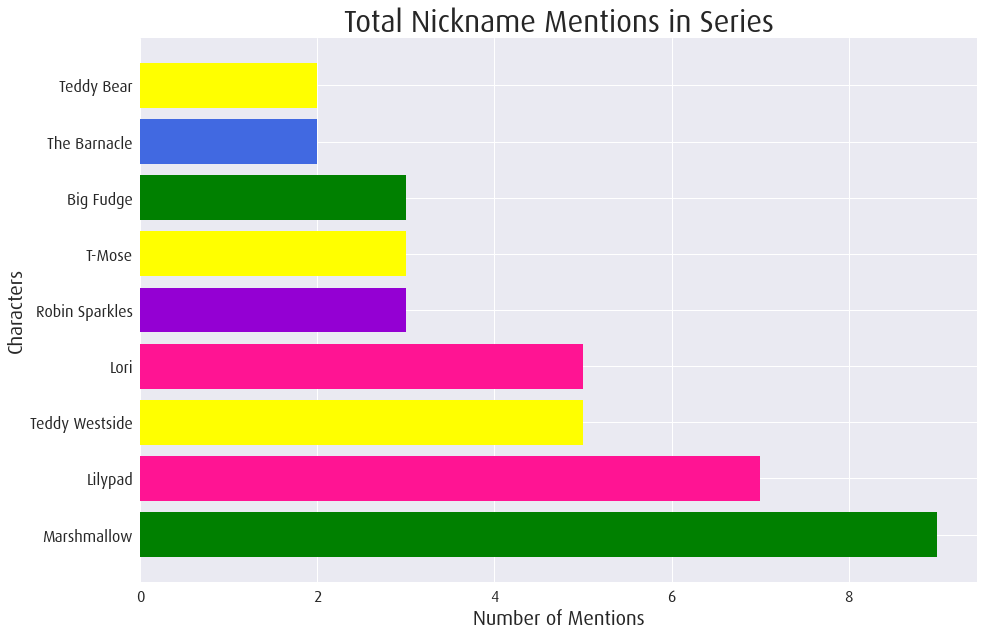

In [17]:
chars = ['Marshmallow', 'Lilypad', 'Teddy Westside', 'Lori', 'Robin Sparkles', 'T-Mose', 'Big Fudge', 
        'The Barnacle', 'Teddy Bear']
mentions = [9, 7, 5, 5, 3, 3, 3, 2, 2]

plt.figure(figsize = (15, 10)) #Set figure size
c = ['green', 'deeppink', 'yellow', 'deeppink', 'darkviolet', 'yellow', 'green', 'royalblue', 'yellow'] #Setting bar colors
plt.barh(chars, mentions, color = c) #Set graph
plt.title('Total Nickname Mentions in Series', size = 30) #Set title of graph
plt.xlabel('Number of Mentions', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Characters', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

## Catchphrases and Largest Vocabulary

Next we'll take a look at who had the largest vocabulary as well as number of mentions of specific catch phrases.

In [18]:
df[df['Line'].str.contains('Lawyered')]

Season Episode Character  \
3508       1      19  Marshall   
3616       1      19  Marshall   
7988       3       4  Marshall   
16753      5      15       Ted   
19507      6       8  Marshall   
20442      6      14  Marshall   
20445      6      14  Marshall   
20449      6      14  Marshall   

                                                    Line Motion  \
3508       Lawyered. The point is, how long has it been?     []   
3616   Lawyered. Okay, three things. First of all, Ro...     []   
7988   One thousand fifty-three and a half times...my...     []   
16753                                          Lawyered.     []   
19507                                          Lawyered.     []   
20442                                    Lawyered. Lily?     []   
20445                                   Lawyered. Robin?     []   
20449  Lawyered. Now can we all just admit that last ...     []   

                  Polarity         Subjectivity  
3508                 -0.05                  0.4  
3616                   0.0   0.3555555555555556  
7988   0.37777777777777777   0.3555555555555556  
16753                  0.0                  0.0  
19507                  0.0                  0.0  
20442                  0.0                  0.0  
20445                  0.0                  0.0  
20449                  0.0  0.08333333333333334

In [103]:
df[df['Line'].str.contains('Canada')]

Season Episode Character  \
5280       2       9       Ted   
5283       2       9     Robin   
5285       2       9     Robin   
5287       2       9     Robin   
5289       2       9       Ted   
5315       2       9       Ted   
5346       2       9    Barney   
5355       2       9  Marshall   
5364       2       9       Ted   
5441       2       9     Robin   
5444       2       9     Robin   
5446       2       9     Robin   
5462       2       9       Ted   
6382       2      15       Ted   
8393       3       7     Robin   
9357       3      15       Ted   
9498       3      16     Robin   
9505       3      16    Barney   
9513       3      16     Robin   
9543       3      16     Robin   
10099      3      19      Lily   
11088      4       6    Barney   
11886      4      11     Robin   
11920      4      11  Marshall   
11947      4      11  Marshall   
11948      4      11     Robin   
11957      4      11  Marshall   
11960      4      11     Robin   
11972      4      11  Marshall   
12396      4      14     Robin   
12404      4      14     Robin   
12461      4      14    Barney   
12505      4      14     Robin   
12509      4      14       Ted   
13081      4      18     Robin   
13131      4      18      Lily   
13135      4      18      Lily   
13223      4      18     Robin   
13225      4      18     Robin   
13996      4      24    Barney   
14916      5       5     Robin   
14958      5       5    Barney   
15017      5       5     Robin   
15039      5       5     Robin   
15074      5       5    Barney   
15083      5       5    Barney   
15085      5       5     Robin   
15467      5       7      Lily   
15470      5       7      Lily   
18808      6       4       Ted   
19645      6       9     Robin   
20853      6      17     Robin   
21022      6      18       Ted   
21024      6      18  Marshall   

                                                    Line  \
5280   Well, I don't know, whenever I ask her about C...   
5283   A friend of mine in Canada got married way too...   
5285   Oh, I like it. Hey, you remember that friend o...   
5287   My friend in Canada who got married way too yo...   
5289   So, you don't think there's any friend from Ca...   
5315   Oh, hey, since you mentioned husbands, this is...   
5346   Don't get too cocky, Slappy. I just got a ship...   
5355   I don't know but I cross-checked every record ...   
5364                   Ah, Canada in June. That's great.   
5441                 I was a teenage pop star in Canada.   
5444   Yes. I had one minor hit. I had to go all over...   
5446       The 80's didn't come to Canada till like '93.   
5462   Hey, just so you know, 16-year-old me would ha...   
6382   Thanks, Canada. I'll take it from here. Barney...   
8393   It's the tallest mountain in Canada. It's like...   
9357   Okay, gun violence might be the answer to ever...   
9498   And old friend from Canada is in town and I'm ...   
9505   Sounds to me like he gave you your first "O, C...   
9513   Yeah. Summer in Canada is pretty much the last...   
9543   So he's not a snob. He's from a different part...   
10099  Yeah. Now she belongs to... CanadaGirlMetroNew...   
11088  My poor. Being forced to grow up in Canada wit...   
11886  I love the passion you have for your Vikings. ...   
11920  With the nearby Canada, Minnesota, we like to ...   
11947  Gary Anderson. He is retired. It was a case of...   
11948  You know what? I'm glad you know it because I ...   
11957  We love you all. If you ever leave again in Ca...   
11960  I miss sometimes. I wish I could close my eyes...   
11972  I think you will recognize. I will throw your ...   
12396  My work permit. If I can not find a job in the...   
12404  Good question, Norm. For the first, I was an i...   
12461  All right. Do not do it. There are many exciti...   
12505  I have not even been taken as the daughter of ...   
12509                           Robin must leave Canada.   
13081  I know not what you call it,

In [19]:
df[df['Line'].str.contains('lawyered')]

Season Episode Character  \
3500       1      19  Marshall   
16751      5      15       Ted   

                                                    Line  \
3500   Aha, so then the oldest profession would be fi...   
16751  Pants. Don's... a duck.  Permission to say "la...   

                                           Motion Polarity Subjectivity  
3500                                           []      0.0          0.0  
16751  ['(Lily and Marshall sigh in awe of Ted)']      0.0          0.0

The catchphrase "Lawyered" is mentioned 10 times.

In [20]:
df[df['Line'].str.contains('Suit up')]

Season Episode Character  \
9          1       1    Barney   
20229      6      13      Lily   

                                                    Line Motion  \
9      Okay, meet me at the bar in fifteen minutes, a...     []   
20229  "Suit up"... not convinced. This whole thing s...     []   

                   Polarity Subjectivity  
9                     0.625          0.5  
20229  -0.07999999999999999         0.48

In [21]:
df[df['Line'].str.contains('suit up')]

Season Episode Character  \
11        1       1    Barney   
484       1       3    Barney   
965       1       6    Barney   
2564      1      13    Barney   
4398      2       2    Barney   
5595      2      10    Barney   
6222      2      14       Ted   
7533      3       1    Barney   

                                                   Line Motion Polarity  \
11    Where's your suit!? Just once when I say suit ...     []      0.0   
484   We're building an igloo in Central Park. It's ...     []      0.5   
965   No, no, not again. Not this year. You're going...     []      0.0   
2564  Ted, oh my gosh, I love this moment. You know ...     []   0.2375   
4398                         Marshall Eriksen, suit up!     []      0.0   
5595  Oh, so now it's my way of life? I thought it w...     []     0.05   
6222  So let me get this straight. A funeral is the ...     []      0.2   
7533  Ted Mosby, suit up, 'cause here's the plan. Th...     []      0.0   

     Subjectivity  
11            0.0  
484         0.625  
965           0.0  
2564        0.425  
4398          0.0  
5595          0.2  
6222          0.4  
7533          0.0

In [22]:
df[df['Line'].str.contains('SUIT UP')]

Season Episode Character  \
121      1       1    Barney   

                                                  Line Motion Polarity  \
121  Okay, meet me at the bar in fifteen minutes-AN...     []    0.625   

    Subjectivity  
121          0.5

The catchphrase "suit up" is mentioned 11 times.

In [23]:
df[df['Line'].str.contains('suit')]

Season Episode Character  \
11         1       1    Barney   
18         1       1    Barney   
19         1       1       Ted   
20         1       1    Barney   
61         1       1    Barney   
...      ...     ...       ...   
20164      6      12       Ted   
20165      6      12    Barney   
20166      6      12       Ted   
20559      6      15       Ted   
21673      6      22    Barney   

                                                    Line  \
11     Where's your suit!? Just once when I say suit ...   
18     Lesson one, lose the goatee. It doesn't look g...   
19                               I'm not wearing a suit.   
20     Lesson two, get a suit. Suits are cool.  Exhib...   
61              Exactly-the guy doesn't even own a suit!   
...                                                  ...   
20164  And you! Ooh. Barney, you look real stupid in ...   
20165  I can't give this suit back. Ted, I glow in th...   
20166  Criminals of New York! Attention! This man is ...   
20559  Blah, blah, blah, I'm an architect. Blah, blah...   
21673  What, wear a wrinkled suit and not give a damn...   

                                                  Motion            Polarity  \
11                                                    []                 0.0   
18                                                    []                 0.7   
19                                                    []                 0.0   
20     ['(Points to self with bear bottle in hand)', ...                 0.3   
61                                                    []                0.75   
...                                                  ...                 ...   
20164                                                 []             -0.4375   
20165                                                 []           -0.084375   
20166                                                 []  0.4161487926136364   
20559                                                 []                 0.0   
21673                                                 []                 0.0   

             Subjectivity  
11                    0.0  
18     0.6000000000000001  
19                    0.0  
20                   0.45  
61                    1.0  
...                   ...  
20164              0.5625  
20165                0.45  
20166  0.4545454545454545  
20559                 0.0  
21673                 0.0  

[95 rows x 7 columns]

WOW, 95 mentions of the word suit!

In [24]:
df[df['Line'].str.contains('suits')]

Season Episode Character  \
2142       1      11    Barney   
2952       1      15    Barney   
2954       1      15    Barney   
3103       1      16    Barney   
8222       3       5    Barney   
8719       3       9    Barney   
9465       3      15  Marshall   
11880      4      11       Ted   
12236      4      13  Marshall   
13253      4      19       Ted   
16270      5      12      Lily   
18185      5      24       Ted   
19535      6       8      Lily   
19579      6       9     Robin   
20108      6      12    Barney   
20559      6      15       Ted   

                                                    Line Motion  \
2142   Yeah, you know why all the circuits are jammed...     []   
2952   She and Greg dated for a while and then split ...     []   
2954   My life rocks! Money, suits and s*x. These are...     []   
3103   Look at us: two guys in suits. You feel that s...     []   
8222   I'm teaching Ted how to live, and lucky you, I...     []   
8719   Well, you didn't ruin it; you made it so much ...     []   
9465   You don't look as good in suits as you think y...     []   
11880  It suits me. Good luck tomorrow at the GNB. I'...     []   
12236  A pack and a size that suits me. Come on, new ...     []   
13253  People freaked out because of a calibrated in ...     []   
16270  arshall, Lily: Nothing suits her better... tha...     []   
18185  This was where I was swimming teacher at Casca...     []   
19535  It's okay. College Lily thinks those are orgas...     []   
19579  Yeah, on the bright side, I guess suits are pr...     []   
20108                                Velour track suits!     []   
20559  Blah, blah, blah, I'm an architect. Blah, blah...     []   

                    Polarity         Subjectivity  
2142     0.09000000000000001  0.43888888888888894  
2952    -0.09687499999999998                0.525  
2954     0.42857142857142855  0.41098901098901097  
3103     0.16666666666666669   0.3333333333333333  
8222      0.2260281385281385   0.6619047619047619  
8719                   -0.25                  0.3  
9465                   0.875   0.6000000000000001  
11880                    0.6   0.7444444444444445  
12236    0.13636363636363635   0.4545454545454545  
13253                    0.0                  0.0  
16270              0.9765625                  0.5  
18185   -0.17142857142857146  0.31428571428571433  
19535     0.1590909090909091  0.23863636363636365  
19579  -0.016666666666666646   0.9333333333333332  
20108                    0.0                  0.0  
20559                    0.0                  0.0

In [25]:
df[df['Line'].str.contains('high five')]

Season Episode Character  \
2659       1      14    Barney   
4332       2       2    Barney   
9879       3      18  Marshall   
18467      6       1    Barney   

                                                    Line Motion  \
2659                    What up! Freeze frame high five!     []   
4332   Yes, I did. But she told me that if it wasn't ...     []   
9879   I miss Barney. I haven't "high five" with anyo...     []   
18467  Dude, you are so in. That is so awesome. A hig...     []   

                   Polarity        Subjectivity  
2659                    0.2  0.5399999999999999  
4332     0.3267857142857143   0.535595238095238  
9879   -0.11333333333333333  0.5133333333333333  
18467    0.4533333333333333  0.6933333333333334

In [26]:
df[df['Line'].str.contains('High five')]

Season Episode Character  \
4575      2       3    Barney   
5681      2      11    Barney   
6265      2      14    Barney   

                                                   Line  \
4575  Robin, I'm his best friend. That's a commitmen...   
5681  Hey, blame Lily and her oppressive "no cigars ...   
6265                  What the hell, I'm in. High five!   

                            Motion             Polarity        Subjectivity  
4575                            []  0.16666666666666674  0.5022222222222221  
5681  ['(he sneezes on his hand)']                 0.16  0.5399999999999999  
6265                            []                  0.2  0.5399999999999999

The catchphrase "high five" is mentioned 7 times.

In [27]:
df[df['Line'].str.contains('legendary')]

Season Episode Character  \
454        1       3    Barney   
470        1       3       Ted   
482        1       3    Barney   
483        1       3       Ted   
484        1       3    Barney   
511        1       3    Barney   
3415       1      18    Barney   
3462       1      18    Barney   
4552       2       3    Barney   
4553       2       3       Ted   
10218      4       1    Barney   
11700      4      10    Barney   
22048      7       1    Barney   

                                                    Line  \
454     MacLaren's is bore, snore. Ted, tonight we're...   
470              Alright, so what's this legendary plan.   
482                Trust me, it's going to be legendary.   
483    Don't say "legendary", okay? You're too libera...   
484    We're building an igloo in Central Park. It's ...   
511    Hey, is that Marshall?  Marshall, stop whateve...   
3415   I said "almost." All those things happened aft...   
3462   Dude, we haen't hit legendary yet. We're only ...   
4552   Uh... I'm here to meet your parents. They must...   
4553   I haven't told them any legendary Barney stories.   
10218  Robin, I was wondering if... Nothing. Gotta go...   
11700  We fought with him. So we will go and tell eve...   
22048  It's not just be someone. This is a market sur...   

                                         Motion            Polarity  \
454    ['(On Phone)', '(High-fives the phone)']                 1.0   
470                                          []                 1.0   
482                                          []                 1.0   
483                                          []  0.8333333333333334   
484                                          []                 0.5   
511                           ['(Takes Phone)']                 1.0   
3415                                         []                 1.0   
3462                                         []                 0.5   
4552                                         []                 1.0   
4553                                         []                 1.0   
10218                                        []  0.3452380952380952   
11700                                        []                 0.6   
22048                                        []                0.65   

             Subjectivity  
454                   1.0  
470                   1.0  
482                   1.0  
483    0.8333333333333334  
484                 0.625  
511                   1.0  
3415                  1.0  
3462                  1.0  
4552                  1.0  
4553                  1.0  
10218  0.7119047619047619  
11700  0.5833333333333334  
22048                 0.5

In [28]:
df[df['Line'].str.contains('Legendary')]

Season Episode Character  \
18951      6       5    Barney   
19779      6      10    Barney   
21879      6      24    Barney   

                                                    Line Motion Polarity  \
18951                Legendary! So, what's on your mind?     []      1.0   
19779  It was legen-- wait for Ted to leave, 'cause h...     []      1.0   
21879  Yeah. Getting to stand next to me while I pres...     []      0.5   

      Subjectivity  
18951          1.0  
19779          1.0  
21879          0.5

The catchphrase "Legendary" is mentioned 16 times.

In [29]:
df[df['Line'].str.contains('wait for it')]

Season Episode Character  \
82         1       1    Barney   
5266       2       9    Barney   
5477       2      10    Barney   
7839       3       3    Barney   
7987       3       4  Marshall   
8866       3      11    Barney   
9812       3      17    Barney   
10255      4       1    Barney   
21175      6      19    Barney   
21879      6      24    Barney   

                                                    Line  \
82                          De-wait for it-nied! Denied!   
5266   Of course I know. She couldn't look at us. Her...   
5477   Yes. And do you know why? Hang on to your beds...   
7839                                    OK, wait for it.   
7987   I am not irrelevant. I ran the numbers. If Lil...   
8866   Which brings us to step 6. You finally realize...   
9812   Oh, no. There is. We're just not going. This i...   
10255  I'm being Barney, and I think tonight's going ...   
21175   You're a master. You are legen... wait for it...   
21879  Yeah. Getting to stand next to me while I pres...   

                          Motion             Polarity         Subjectivity  
82     ['(comes back laughing)']                  0.0                  0.0  
5266                          []                  0.0                  0.0  
5477                          []   0.2857142857142857   0.5357142857142857  
7839                          []                  0.5                  0.5  
7987                          []  0.19285714285714287   0.5214285714285715  
8866                          []   0.1340909090909091                 0.85  
9812                          []  0.08214285714285714  0.18571428571428567  
10255                         []                  1.0                  1.0  
21175                         []                  0.0                  0.0  
21879                         []                  0.5                  0.5

In [30]:
df[df['Line'].str.contains('Wait for it')]

Season Episode Character  \
3895       1      21       Ted   
4460       2       2    Barney   
5683       2      11    Barney   
7530       2      22    Barney   
18944      6       5    Barney   
20959      6      18    Barney   

                                                    Line  \
3895                                        Wait for it.   
4460   Oh, but it is. She has... Wait for it. Here it...   
5683   Oh, Robin, my simple friend from the untamed n...   
7530   Yes! Yes! We're back. We are back. And Ted, my...   
18944  Sick. Yeah. Dude. Working together is gonna be...   
20959  And she is indeed hot. Which is why nothing, n...   

                          Motion               Polarity        Subjectivity  
3895                          []                    0.0                 0.0  
4460                          []                    0.0                 0.0  
5683   ['(Barney falls asleep)']  -0.038010204081632665  0.6030612244897959  
7530                          []                    0.0                 0.0  
18944                         []    -0.8928571428571429  0.8571428571428571  
20959           ['(He sneezes)']                   0.25  0.8500000000000001

The catchphrase "wait for it" is mentioned 16 times.

In [31]:
q3 = pd.read_sql("""
SELECT Character, Line
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
;
""", conn)

q3

Character                                               Line
0      Marshall                                 Will you marry me.
1           Ted  Yes, perfect! And then you're engaged, you pop...
2      Marshall  Got it. Thanks for helping me plan this out, Ted.
3           Ted  Dude, are you kidding? It's you and Lily! I've...
4      Marshall           yeah, sorry. We thought you were asleep.
...         ...                                                ...
22470  Marshall                                 It is so much fun.
22471  Marshall                               I love crushed nuts.
22472    Barney  "I'm probably saying some political stuff righ...
22473    Barney                Whoa. Is there going to be a fight?
22474       Ted                                     They're happy.

[22475 rows x 2 columns]

In [32]:
q3.Line = q3.Line.apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x)) #Removing all non alphabet characters

q3.Line = q3.Line.str.lower() #Making everything lowercase

q3 #Checking q3

Character                                               Line
0      Marshall                                  will you marry me
1           Ted  yes perfect and then youre engaged you pop the...
2      Marshall     got it thanks for helping me plan this out ted
3           Ted  dude are you kidding its you and lily ive been...
4      Marshall              yeah sorry we thought you were asleep
...         ...                                                ...
22470  Marshall                                  it is so much fun
22471  Marshall                                i love crushed nuts
22472    Barney  im probably saying some political stuff right ...
22473    Barney                  whoa is there going to be a fight
22474       Ted                                       theyre happy

[22475 rows x 2 columns]

In [33]:
from collections import Counter
tedwords = Counter()
marshwords = Counter()
barnwords = Counter()
robwords = Counter()
lilwords = Counter()


q3[q3['Character'] == 'Ted'].Line.str.lower().str.split().apply(tedwords.update)
q3[q3['Character'] == 'Marshall'].Line.str.lower().str.split().apply(marshwords.update)
q3[q3['Character'] == 'Barney'].Line.str.lower().str.split().apply(barnwords.update)
q3[q3['Character'] == 'Robin'].Line.str.lower().str.split().apply(robwords.update)
q3[q3['Character'] == 'Lily'].Line.str.lower().str.split().apply(lilwords.update)

display(len(tedwords))
display(len(marshwords))
display(len(barnwords))
display(len(robwords))
display(len(lilwords))

6853

5369

6622

4500

4237

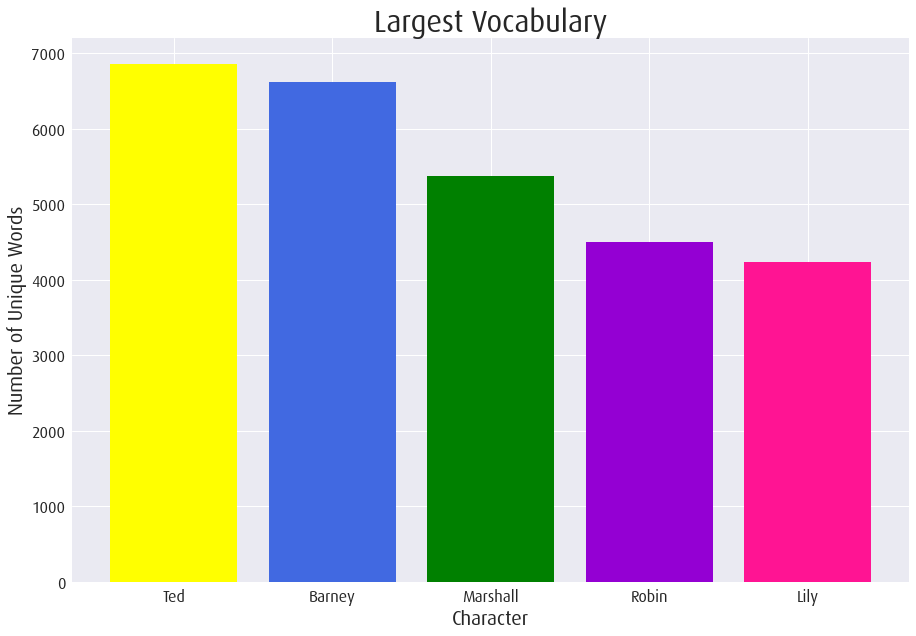

In [34]:
chars = ['Ted', 'Barney', 'Marshall', 'Robin', 'Lily']
mentions = [6853, 6622, 5369, 4500, 4237]

plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'green', 'darkviolet', 'deeppink'] #Setting bar colors
plt.bar(chars, mentions, color = c) #Set graph
plt.title('Largest Vocabulary', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Unique Words', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

I might come back and remake this graph with their most used words placed on their bars. We'll see. Let's keep going!

## Frequency Distributions, WordClouds, Ngrams, and Mutual Information Scores

Next we'll be looking at a few different word exploration devices: frequency distributions to see how often the most common terms appear per character, wordclouds to visualize each character's most common terms, ngrams to look at the most common two through five word phrases per character, and mutual information scores, which is the score of an association between two tokens that a character spoke. All of these explorations will give us more information about the differences between each character's lines. Following this we'll take a look at sentiment.

### Setting Everything Up

In the following cells I set up my character dataframes and token lists and take a look at the total number of tokens in the corpus and per character. This is to get a general idea of the spread before I take the deep dive.

In [35]:
nltk_stopwords = stopwords.words('english') #Pulling up NLTK stopwords
nltk_stopwords.sort() #Sorting stopwords alphabetically
print(nltk_stopwords) #Printing list of sorted NLTK stopwords

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [96]:
new_stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 
                 'are', 'aren', "arent", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 
                 'between', 'both', 'but', 'by', 'can', 'couldn', "couldnt", 'd', 'did', 'didn', "didnt", 'do', 
                 'does', 'doesn', "doesnt", 'doing', 'don', "dont", 'down', 'during', 'each', 'few', 'for', 'from', 
                 'further', 'had', 'hadn', "hadnt", 'has', 'hasn', "hasnt", 'have', 'haven', "havent", 'having', 
                 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 
                 'is', 'im', 'isn', "isnt", 'it', "its", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', 
                 "mightnt", 'more', 'most', 'mustn', "mustnt", 'my', 'myself', 'needn', "neednt", 'no', 'nor', 'ive', 
                 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 
                 'out', 'over', 'own', 're', 's', 'same', 'shan', "shant", 'she', "shes", 'should', "shouldve", 
                 'shouldn', "shouldnt", 'so', 'some', 'such', 't', 'than', 'that', 'thats', "thatll", 'the', 'their', 
                 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 
                 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasnt", 'we', 'were', 
                 'weren', "werent", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 
                 'with', 'won', "wont", 'wouldn', "wouldnt", 'y', 'you', "youd", "youll", "youre", "youve", 'your', 
                 'yours', 'yourself', 'yourselves', 'would', 'go', 'yeah', 'yes', 'well', 'get', 'okay', 
                'got', 'oh', 'like', 'wan', 'na', 'gon', 'theyre'] #New list

In [37]:
def remstopandtok(text): #function to remove stopwords and tokenize line
    return [word for word in word_tokenize(text) if not word in new_stopwords] #returns tokens without stopwords

q3['Tokens'] = q3.Line.apply(lambda x: remstopandtok(x)) #Applying function to build new column

q3.head() #Reviewing df to make sure column was added

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

In [38]:
Ted_DF = q3['Tokens'].loc[q3['Character'] == 'Ted'] #New DF of only tokens spoken by Ted
Marshall_DF = q3['Tokens'].loc[q3['Character'] == 'Marshall'] #New DF of only tokens spoken by Marshall
Barney_DF = q3['Tokens'].loc[q3['Character'] == 'Barney'] #New DF of only tokens spoken by Barney
Robin_DF = q3['Tokens'].loc[q3['Character'] == 'Robin'] #New DF of only tokens spoken by Robin
Lily_DF = q3['Tokens'].loc[q3['Character'] == 'Lily'] #New DF of only tokens spoken by Lily

tokens = [] #Instantiating total token list
ted_tokens = [] #Instantiation ted token list
marshall_tokens = [] #Instantiation marshall token list
barney_tokens = [] #Instantiation barney token list
robin_tokens = [] #Instantiation robin token list
lily_tokens = [] #Instantiation lily token list

for row in q3['Tokens']:
    tokens.extend(row) #Populating token list from df
for row in Ted_DF:
    ted_tokens.extend(row) #Populating token list from df
for row in Marshall_DF:
    marshall_tokens.extend(row) #Populating token list from df
for row in Barney_DF:
    barney_tokens.extend(row) #Populating token list from df
for row in Robin_DF:
    robin_tokens.extend(row) #Populating token list from df
for row in Lily_DF:
    lily_tokens.extend(row) #Populating token list from df

print(f'Total Corpus Tokens: {len(tokens)}') #Print total number of tokens
print(f'Number of Ted Tokens: {len(ted_tokens)}') #Print number of ted tokens
print(f'Number of Marshall Tokens: {len(marshall_tokens)}') #Print number of marshall tokens
print(f'Number of Barney Tokens: {len(barney_tokens)}') #Print number of barney tokens
print(f'Number of Robin Tokens: {len(robin_tokens)}') #Print number of robin tokens
print(f'Number of Lily Tokens: {len(lily_tokens)}') #Print number of lily tokens

Total Corpus Tokens: 121184
Number of Ted Tokens: 34513
Number of Marshall Tokens: 22927
Number of Barney Tokens: 28675
Number of Robin Tokens: 17994
Number of Lily Tokens: 17075


### Frequency Distributions

In [39]:
Corpus_FreqDist = FreqDist(tokens) #Instantiating corpus freqdist
Ted_FreqDist = FreqDist(ted_tokens) #Instantiating ted freqdist
Marshall_FreqDist = FreqDist(marshall_tokens) #Instantiating marshall freqdist
Barney_FreqDist = FreqDist(barney_tokens) #Instantiating barney freqdist
Robin_FreqDist = FreqDist(robin_tokens) #Instantiating robin freqdist
Lily_FreqDist = FreqDist(lily_tokens) #Instantiating lily freqdist

print('Top 25 Used Terms in Corpus:') #Printing title for corpus results
print(Corpus_FreqDist.most_common(25)) #Printing 25 most common corpus tokens
print('') #Printing space
print("Top 25 Used Terms in Ted's Lines:") #Printing title for ted's results
print(Ted_FreqDist.most_common(25)) #Printing 25 most common ted tokens
print('') #Printing space
print("Top 25 Used Terms in Marshall's Lines:") #Printing title for marshall's results
print(Marshall_FreqDist.most_common(25)) #Printing 25 most common marshall tokens
print('') #Printing space
print("Top 25 Used Terms in Barney's Lines:") #Printing title for barney's results
print(Barney_FreqDist.most_common(25)) #Printing 25 most common barney tokens
print('') #Printing space
print("Top 25 Used Terms in Robin's Lines:") #Printing title for robin's results
print(Robin_FreqDist.most_common(25)) #Printing 25 most common robin tokens
print('') #Printing space
print("Top 25 Used Terms in Lily's Lines:") #Printing title for lily's results
print(Lily_FreqDist.most_common(25)) #Printing 25 most common lily tokens

Top 25 Used Terms in Corpus:
[('know', 1740), ('ted', 1226), ('right', 1010), ('one', 912), ('want', 860), ('really', 808), ('lily', 771), ('barney', 769), ('think', 749), ('going', 737), ('robin', 718), ('marshall', 706), ('hey', 685), ('good', 673), ('guys', 631), ('look', 614), ('see', 591), ('say', 573), ('love', 570), ('come', 569), ('time', 555), ('tell', 480), ('great', 478), ('sorry', 463), ('never', 458)]

Top 25 Used Terms in Ted's Lines:
[('know', 484), ('right', 331), ('one', 264), ('really', 253), ('think', 251), ('want', 241), ('robin', 237), ('barney', 234), ('good', 219), ('hey', 215), ('lily', 213), ('going', 211), ('marshall', 208), ('look', 205), ('ted', 201), ('guys', 189), ('come', 187), ('see', 183), ('say', 169), ('time', 162), ('great', 160), ('uh', 151), ('love', 146), ('wait', 137), ('tell', 132)]

Top 25 Used Terms in Marshall's Lines:
[('know', 371), ('lily', 259), ('ted', 234), ('right', 204), ('think', 164), ('one', 148), ('want', 145), ('hey', 144), ('rea

Seeing a lot of similar terms, which means if we end up making a model that is predicting their lines it could be hard to distinguish between characters. Some common terms other than transitional words (like, yeah, go, want, etc.) are character names. This makes sense with what we saw earlier when we looked at total character mentions and nickname mentions. Let's move on to wordclouds so we can visualize these terms!

### WordClouds

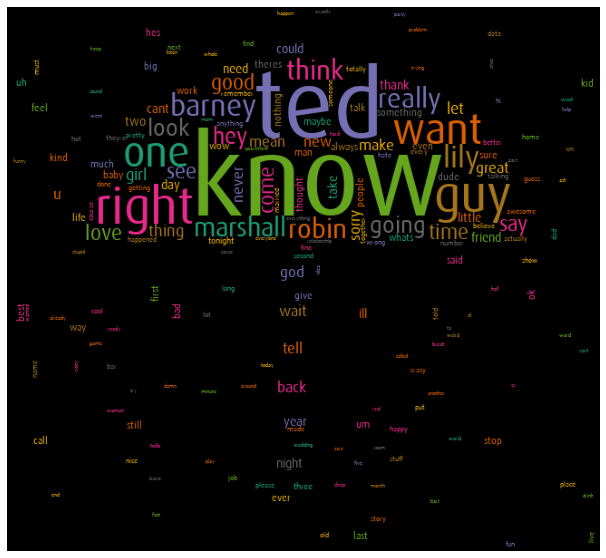

In [40]:
def make_wordcloud(tokens, colormap, mask = None): #Defining function to make word clouds
    """
    Function takes in list of tokens, color, and a mask for an image shape 
    if desired and creates a word cloud of the token list; if mask is set the wordcloud
    will be in the shape of the mask.
    """
    plt.figure(figsize = (15, 10)) #Instantiate plot and set figure size
    
    wc = WordCloud(font_path = 'Images/Dax.ttf', max_words = 200, stopwords = new_stopwords, collocations = False, 
                   mask = mask, width = 1500, height = 1000, 
                   colormap = colormap).generate(" ".join(tokens)) #Instantiate wordcloud
    
    plt.imshow(wc) #Show word cloud
    
    plt.axis('off') #Turn off xy axis
    
mask = np.array(Image.open('Images/umb2.png')) #Setting mask to image shape
make_wordcloud(tokens, 'Dark2', mask = mask) #Plotting word cloud of all tokens

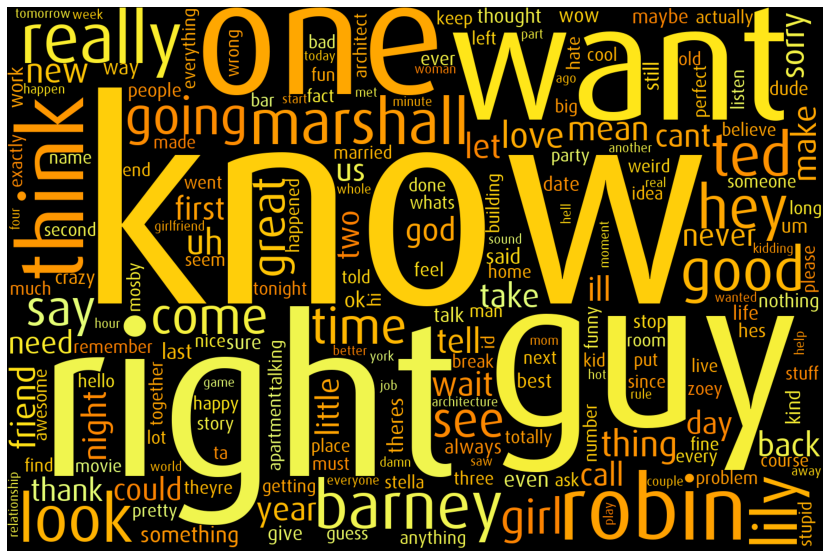

In [41]:
make_wordcloud(ted_tokens, 'Wistia', mask = None) #Plotting word cloud of ted tokens

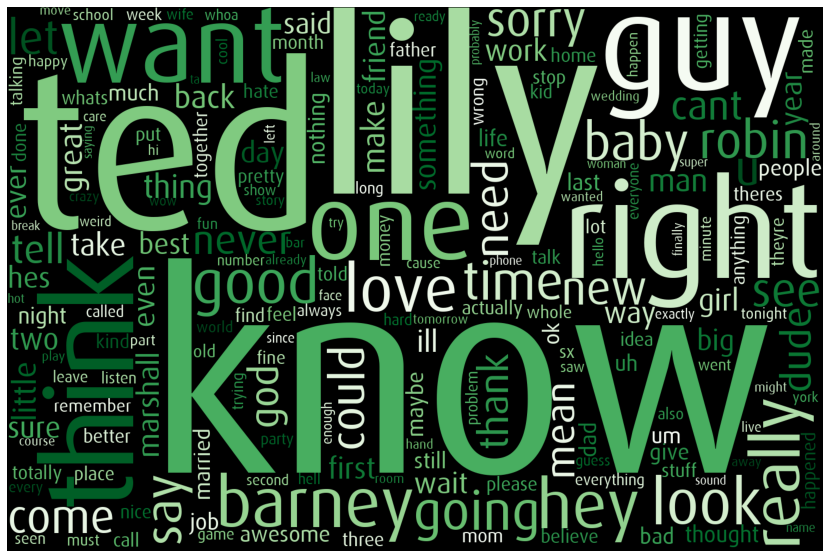

In [42]:
make_wordcloud(marshall_tokens, 'Greens', mask = None) #Plotting word cloud of marshall tokens

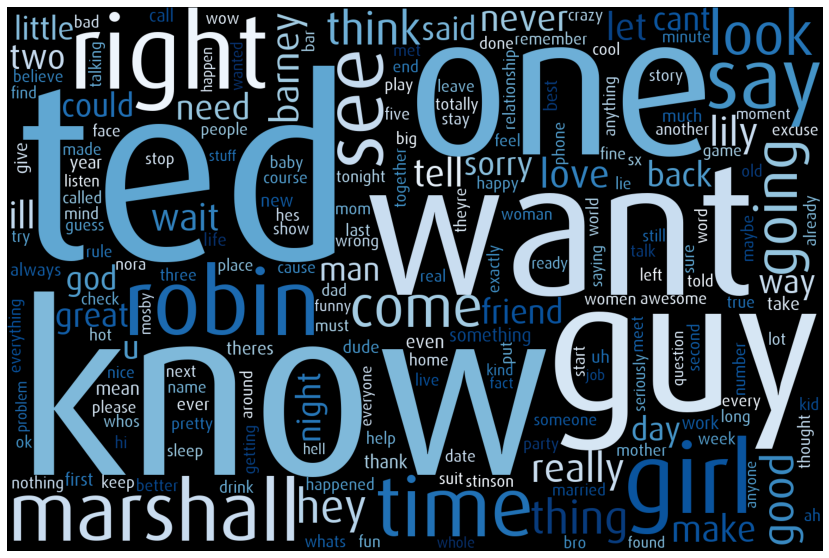

In [43]:
make_wordcloud(barney_tokens, 'Blues', mask = None) #Plotting word cloud of barney tokens

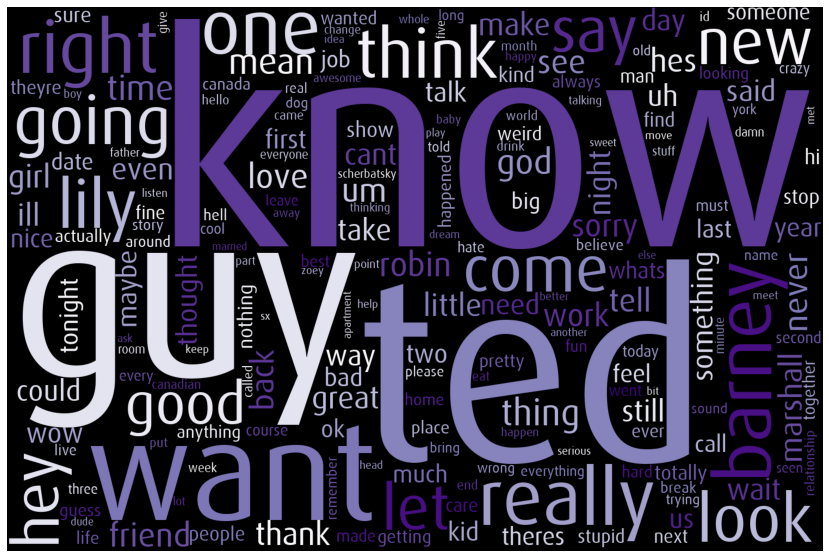

In [44]:
make_wordcloud(robin_tokens, 'Purples', mask = None) #Plotting word cloud of robin tokens

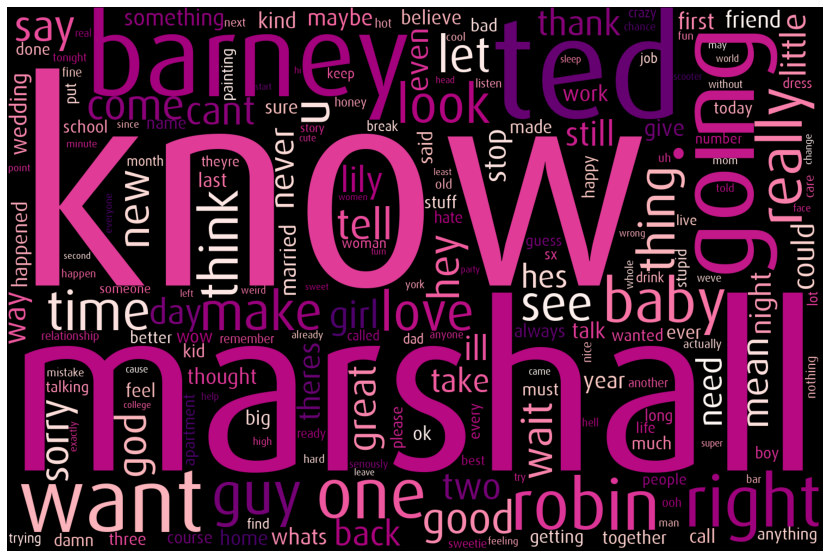

In [45]:
make_wordcloud(lily_tokens, 'RdPu', mask = None) #Plotting word cloud of lily tokens

Reviewing the wordclouds helps provide a little more clarity between the most used terms. Specific names are used more between specific characters. Lily and Marshall refer to each other more often than others, which makes sense since their storyline involves their relationship evolving into marriage. Unfortunately, I was hoping more of the most used words would be more important and provide more insight but there isn't much. An example would be the words "wedding" and "painting" on Lily's wordcloud, which make sense because she is an artist and got married in season 2, so those are two things she discusses more than once. Let's take a look at ngrams now to see if we can provide more clarity.

### Ngrams

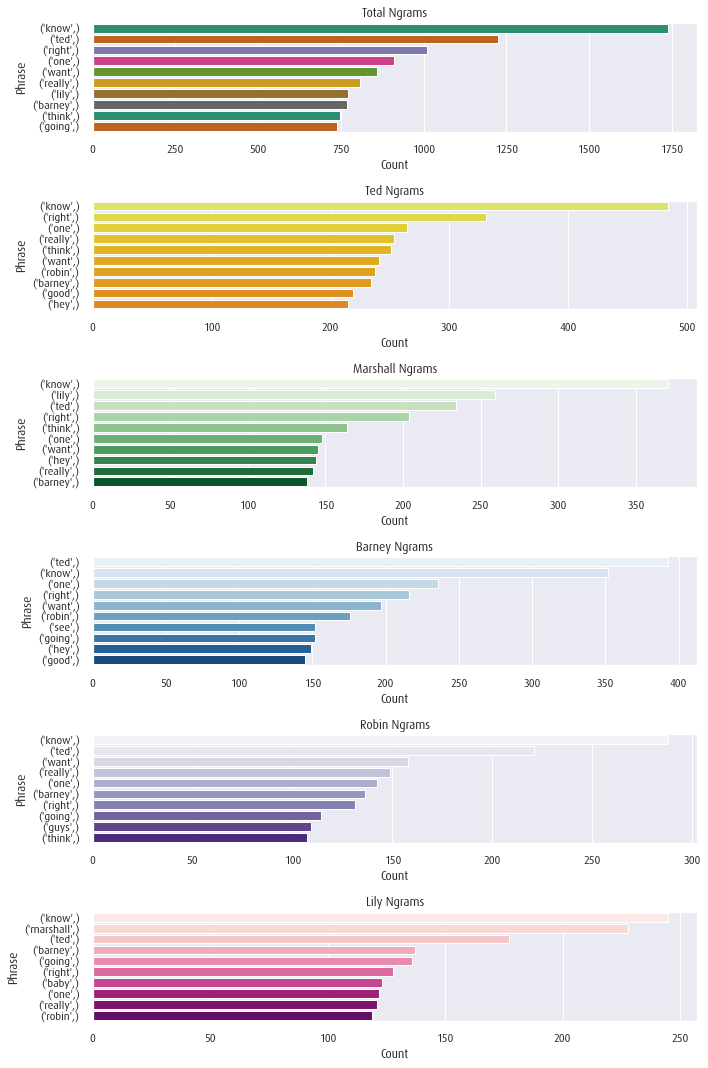

In [46]:
def make_ngram(i, tokens = tokens, ted_tokens = ted_tokens, marshall_tokens = marshall_tokens, 
              barney_tokens = barney_tokens, robin_tokens = robin_tokens, lily_tokens = lily_tokens): #define function
    """
    Function takes in a number that will be the amount of tokens in the phrase and
    displays the 10 most common phrases of that number of tokens for each token list.
    """
    
    n_gram_tot = (pd.Series(nltk.ngrams(tokens, i)).value_counts())[:10] #Setting up total ngrams
    n_gram_ted = (pd.Series(nltk.ngrams(ted_tokens, i)).value_counts())[:10] #Setting up ted ngrams
    n_gram_marshall = (pd.Series(nltk.ngrams(marshall_tokens, i)).value_counts())[:10] #Setting up marshall ngrams
    n_gram_barney = (pd.Series(nltk.ngrams(barney_tokens, i)).value_counts())[:10] #Setting up barney ngrams
    n_gram_robin = (pd.Series(nltk.ngrams(robin_tokens, i)).value_counts())[:10] #Setting up robin ngrams
    n_gram_lily = (pd.Series(nltk.ngrams(lily_tokens, i)).value_counts())[:10] #Setting up lily ngrams
    
    n_gram_df_tot = pd.DataFrame(n_gram_tot) #Creating total ngram df
    n_gram_df_ted = pd.DataFrame(n_gram_ted) #Creating ted ngram df
    n_gram_df_marshall = pd.DataFrame(n_gram_marshall) #Creating marshall ngram df
    n_gram_df_barney = pd.DataFrame(n_gram_barney) #Creating barney ngram df
    n_gram_df_robin = pd.DataFrame(n_gram_robin) #Creating robin ngram df
    n_gram_df_lily = pd.DataFrame(n_gram_lily) #Creating lily ngram df
    
    n_gram_df_tot = n_gram_df_tot.reset_index() #Resetting index
    n_gram_df_ted = n_gram_df_ted.reset_index() #Resetting index
    n_gram_df_marshall = n_gram_df_marshall.reset_index() #Resetting index
    n_gram_df_barney = n_gram_df_barney.reset_index() #Resetting index
    n_gram_df_robin = n_gram_df_robin.reset_index() #Resetting index
    n_gram_df_lily = n_gram_df_lily.reset_index() #Resetting index
    
    n_gram_df_tot = n_gram_df_tot.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming total plot
    n_gram_df_ted = n_gram_df_ted.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming ted plot
    n_gram_df_marshall = n_gram_df_marshall.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming marshall plot
    n_gram_df_barney = n_gram_df_barney.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming barney plot
    n_gram_df_robin = n_gram_df_robin.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming robin plot
    n_gram_df_lily = n_gram_df_lily.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming lily plot
    
    with sns.axes_style('darkgrid'): #Setting seaborn to darkgrid style
        
        sns.set_theme(font = 'Dax')
        fig = plt.figure(figsize = (10, 15)) #Setting figsize
        ax1 = fig.add_subplot(611) #Stacking first figure
        ax2 = fig.add_subplot(612) #Stacking second figure
        ax3 = fig.add_subplot(613) #Stacking third figure
        ax4 = fig.add_subplot(614) #Stacking fourth figure
        ax5 = fig.add_subplot(615) #Stacking fifth figure
        ax6 = fig.add_subplot(616) #Stacking sixth figure
        
        sns.barplot(ax = ax1, x = 'Count', y = 'Phrase', data = n_gram_df_tot, 
                    palette = 'Dark2').set(title = 'Total Ngrams') #Assigning barplot to total ngrams
        sns.barplot(ax = ax2, x = 'Count', y = 'Phrase', data = n_gram_df_ted, 
                    palette = 'Wistia').set(title = 'Ted Ngrams') #Assigning barplot to ted ngrams
        sns.barplot(ax = ax3, x = 'Count', y = 'Phrase', data = n_gram_df_marshall, 
                    palette = 'Greens').set(title = 'Marshall Ngrams') #Assigning barplot to marshall ngrams
        sns.barplot(ax = ax4, x = 'Count', y = 'Phrase', data = n_gram_df_barney, 
                    palette = 'Blues').set(title = 'Barney Ngrams') #Assigning barplot to barney ngrams
        sns.barplot(ax = ax5, x = 'Count', y = 'Phrase', data = n_gram_df_robin, 
                    palette = 'Purples').set(title = 'Robin Ngrams') #Assigning barplot to robin ngrams
        sns.barplot(ax = ax6, x = 'Count', y = 'Phrase', data = n_gram_df_lily, 
                    palette = 'RdPu').set(title = 'Lily Ngrams') #Assigning barplot to lily ngrams
    
    plt.tight_layout() #Make plot layouts tight
    
make_ngram(1) #Plot 1 word ngrams

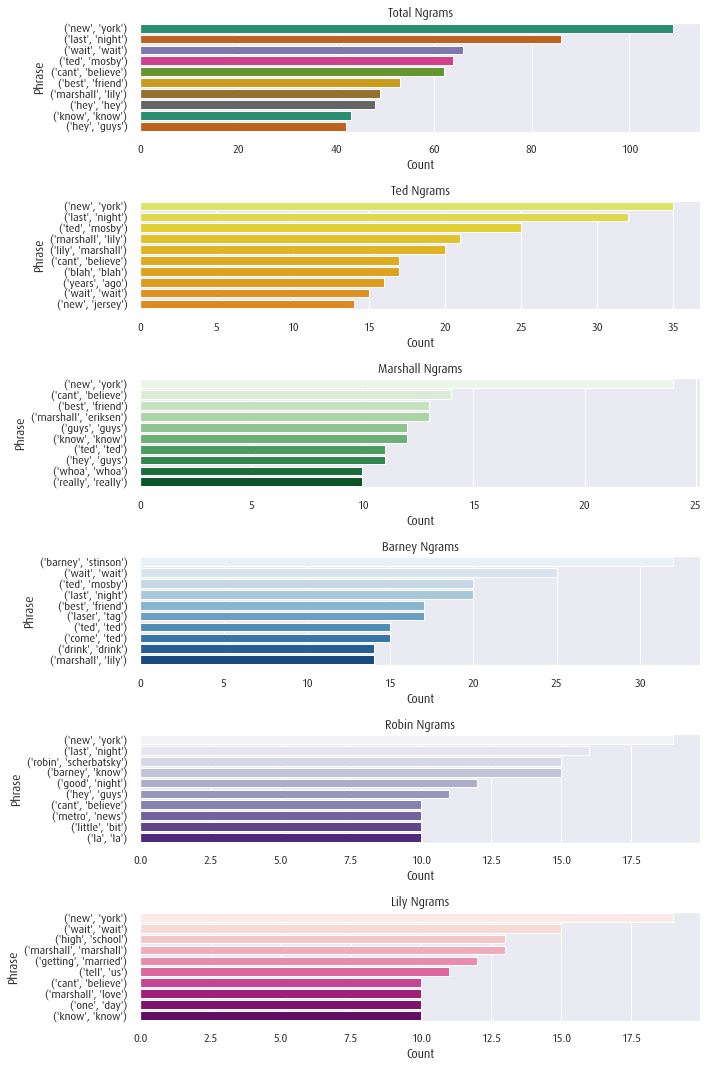

In [47]:
make_ngram(2) #Plot 2 word ngrams

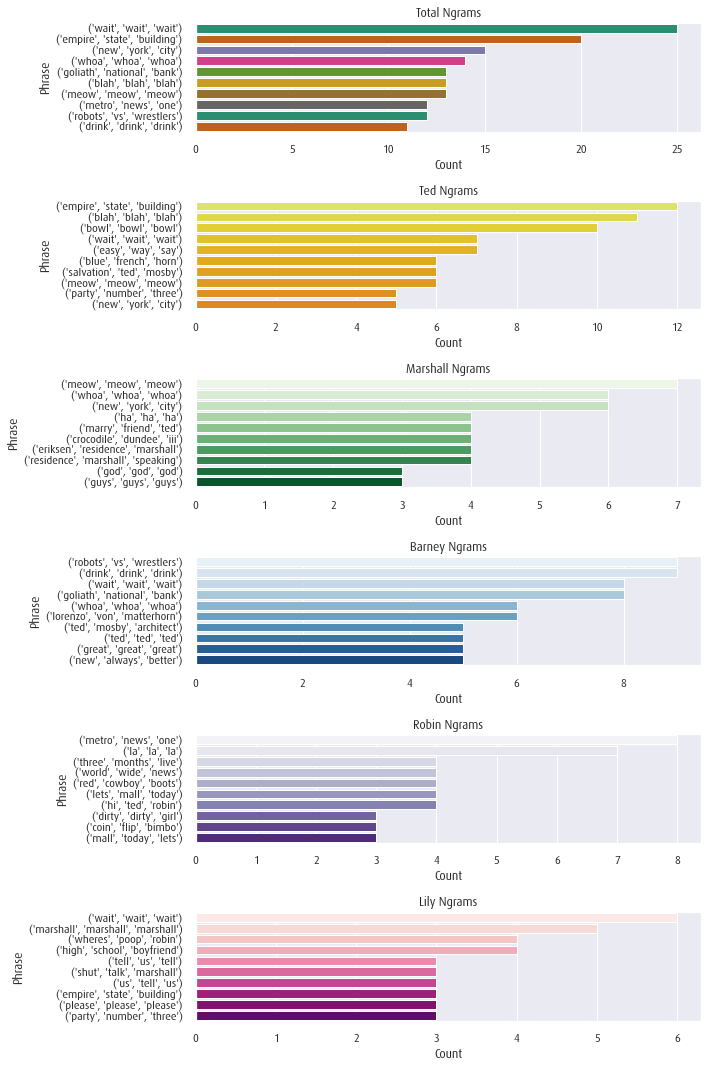

In [48]:
make_ngram(3) #Plot 3 word ngrams

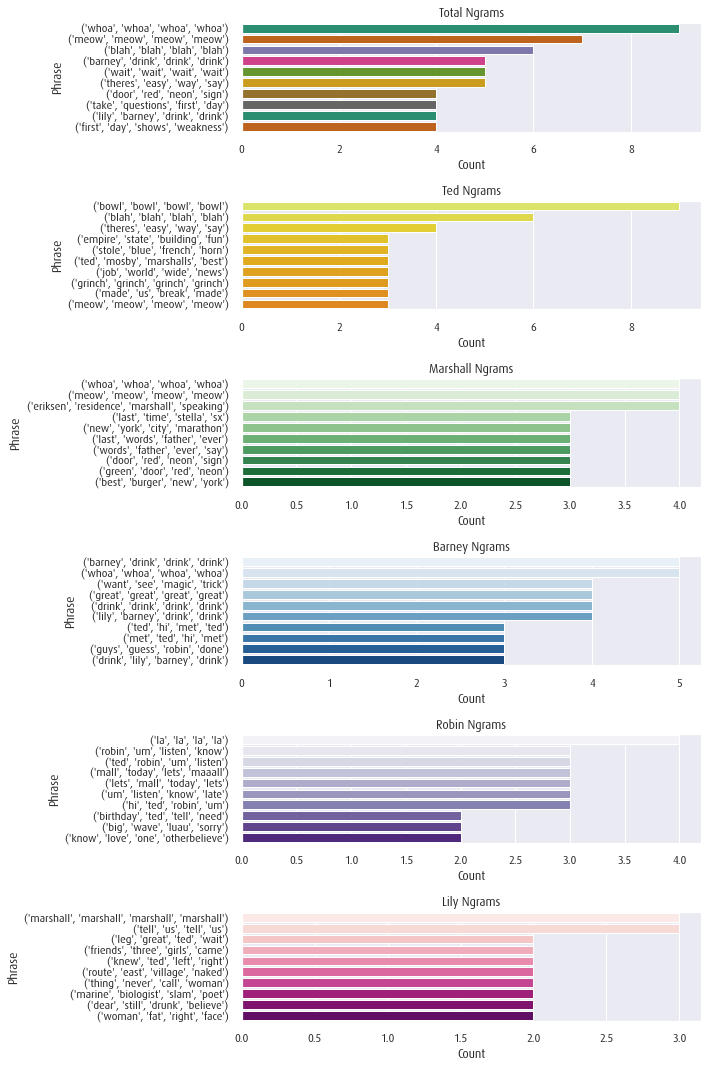

In [49]:
make_ngram(4) #Plot 4 word ngrams

We're seeing some differences here as our phrases grow by the number of words. Three word ngrams give us the biggest differences between characters, and I'm seeing memorable lines, as well as repetitive lines.

### Mutual Information Scores

In [50]:
def calc_bigram(tokens, filter_count): #Defining function to show and calculate mutual information scores
    """
    Function takes in list of tokens and minimum number of times pair of tokens needs to
    show up for a mutual information score to be calculated.
    """
    
    bigram_measures = nltk.collocations.BigramAssocMeasures() #Instantiating Bigram Association Measures
    
    tokens_pmi_finder = BigramCollocationFinder.from_words(tokens) #Instantiating Bigram Collocation Finder
    
    tokens_pmi_finder.apply_freq_filter(filter_count) #Setting minimum amount of times bigram must appear
    
    tokens_pmi_scored = tokens_pmi_finder.score_ngrams(bigram_measures.pmi) #Scoring tokens from bigrams
    
    return tokens_pmi_scored #Show scores

calc_bigram(tokens, 25) #Looking at bigrams of all tokens

[(('laser', 'tag'), 11.97639129086271),
 (('high', 'school'), 9.659581529376158),
 (('whoa', 'whoa'), 8.746061050101623),
 (('new', 'york'), 8.193033080075773),
 (('new', 'jersey'), 8.184897962578097),
 (('years', 'ago'), 7.59887087001203),
 (('big', 'deal'), 7.571690143628118),
 (('three', 'days'), 7.567000354725009),
 (('three', 'months'), 7.236003358394358),
 (('little', 'bit'), 7.186738370538567),
 (('best', 'friend'), 7.0657877784611),
 (('barney', 'stinson'), 6.910957627176696),
 (('last', 'night'), 6.744035074232766),
 (('robin', 'scherbatsky'), 6.714501497789298),
 (('getting', 'married'), 6.650302243153643),
 (('cant', 'believe'), 6.492238716120536),
 (('ted', 'mosby'), 6.012386598078429),
 (('whole', 'thing'), 6.003109637104819),
 (('best', 'friends'), 5.956603126090563),
 (('wait', 'wait'), 5.284499345150401),
 (('thank', 'god'), 5.174262131590773),
 (('every', 'time'), 5.03630723515132),
 (('last', 'time'), 4.701147697956216),
 (('ill', 'tell'), 4.20622496609958),
 (('whats

In [51]:
calc_bigram(ted_tokens, 10) #Looking at bigrams of ted tokens

[(('empire', 'state'), 11.074852263262331),
 (('bowl', 'bowl'), 10.359358199398946),
 (('jen', 'coulin'), 10.236909021371305),
 (('blah', 'blah'), 10.115191192398646),
 (('state', 'building'), 9.10522591230585),
 (('big', 'deal'), 8.16796166765381),
 (('new', 'jersey'), 8.086167576490164),
 (('new', 'york'), 7.967523079991546),
 (('party', 'number'), 7.6766018847298305),
 (('years', 'ago'), 7.58801724169928),
 (('best', 'friend'), 7.381365305763005),
 (('ge', 'ted'), 7.3083233546634645),
 (('little', 'bit'), 7.052484450233877),
 (('last', 'night'), 6.672239859755688),
 (('ted', 'mosby'), 6.64139200715603),
 (('cant', 'believe'), 6.446782040986088),
 (('best', 'friends'), 6.02291133485053),
 (('plus', 'one'), 5.846033572766446),
 (('wait', 'wait'), 4.785678692949794),
 (('ill', 'tell'), 4.696557407350438),
 (('one', 'thing'), 4.056453352436822),
 (('marshall', 'lily'), 4.032020347674161),
 (('lily', 'marshall'), 3.9616310197827627),
 (('guys', 'guys'), 3.40979903345748),
 (('hey', 'guys

In [52]:
calc_bigram(marshall_tokens, 10) #Looking at bigrams of marshall tokens

[(('meow', 'meow'), 10.405808628647886),
 (('high', 'school'), 9.255941279546828),
 (('whoa', 'whoa'), 8.405808628647886),
 (('new', 'york'), 8.21797342934781),
 (('last', 'words'), 8.162831875155346),
 (('marshall', 'eriksen'), 7.659678879088734),
 (('best', 'friend'), 7.081911879771782),
 (('cant', 'believe'), 6.568453947690331),
 (('guys', 'guys'), 4.024986844706959),
 (('hey', 'guys'), 3.751898774209243),
 (('really', 'really'), 3.507193825920707),
 (('hey', 'hey'), 3.4668380620454453),
 (('ted', 'ted'), 2.2034621495132),
 (('know', 'ted'), 1.401047968725866),
 (('know', 'know'), 0.9991717175222625)]

In [53]:
calc_bigram(barney_tokens, 10) #Looking at bigrams of barney tokens

[(('laser', 'tag'), 10.637580864348237),
 (('new', 'york'), 8.853309555403676),
 (('barney', 'stinson'), 7.495757550785589),
 (('drink', 'drink'), 7.270010103905163),
 (('last', 'night'), 6.924862816428707),
 (('best', 'friend'), 6.873294664182518),
 (('cant', 'believe'), 6.405850578432455),
 (('thank', 'god'), 6.19463736849951),
 (('ted', 'mosby'), 5.8106087402782105),
 (('wait', 'wait'), 5.5898873804394995),
 (('marshall', 'lily'), 4.399707015568575),
 (('met', 'ted'), 4.381765441474338),
 (('ill', 'tell'), 4.3172566551634635),
 (('hey', 'hey'), 3.954131325587383),
 (('one', 'thing'), 3.9248628164287105),
 (('want', 'see'), 3.744881454948194),
 (('come', 'ted'), 2.9979788761799355),
 (('robin', 'know'), 2.2105707234033165),
 (('ted', 'ted'), 1.4776254568818565),
 (('ted', 'know'), 1.3146512456158028)]

In [54]:
calc_bigram(robin_tokens, 10) #Looking at bigrams of robin tokens

[(('la', 'la'), 10.056276966195075),
 (('metro', 'news'), 8.479876478977342),
 (('new', 'york'), 8.181031997203023),
 (('robin', 'scherbatsky'), 7.479876478977346),
 (('little', 'bit'), 7.303604370769149),
 (('cant', 'believe'), 6.906409617094017),
 (('last', 'night'), 6.788714574424263),
 (('good', 'night'), 5.136637877844567),
 (('hey', 'guys'), 4.168264118698472),
 (('barney', 'know'), 2.7847310605057647),
 (('ted', 'know'), 1.499328841643516)]

In [55]:
calc_bigram(lily_tokens, 10) #Looking at bigrams of lily tokens

[(('high', 'school'), 8.732131679636023),
 (('new', 'york'), 7.830779267568932),
 (('getting', 'married'), 7.218295704083877),
 (('cant', 'believe'), 6.164780194756872),
 (('wait', 'wait'), 5.508851172681572),
 (('one', 'day'), 4.92722675933228),
 (('tell', 'us'), 4.883311456371066),
 (('marshall', 'love'), 3.0094772276794046),
 (('marshall', 'marshall'), 2.0942576478764234),
 (('know', 'know'), 1.508250174947035)]

We're seeing some more specific differences here. These differences make sense in the context of the characters, as well as their relationships to each other. Taking a peak at the sentiment of each character next will certainly make the differences clearer.

## Sentiment Scores

For each line, a polarity and subjectivity score was calculated (done in the previous notebook). These scores represent the sentiment of the line (how positive or negative it was, measured from -1 to 1) and how subjective or objective the line was (0 being very objective and 1 being very subjective). Looking at these scores can tell us more about the character development over episodes and seasons, and can help inform what we want to model.

In [56]:
q4 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Ted', 'Marshall', 'Barney', 'Robin', 'Lily')
GROUP BY Season, Episode, Character
;
""", conn)

q4

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1    Barney      0.172737          0.281741
1        1       1      Lily      0.074928          0.414778
2        1       1  Marshall      0.004677          0.228136
3        1       1     Robin      0.114525          0.225241
4        1       1       Ted      0.139807          0.261053
..     ...     ...       ...           ...               ...
689      8       7      Lily     -0.262500          0.350000
690      8       7  Marshall      0.000000          0.000000
691      8       7       Ted     -0.033333          0.066667
692      8       9     Robin     -0.140278          0.331944
693      8       9       Ted      0.000000          0.500000

[694 rows x 5 columns]

In [57]:
s1epsent = q4[q4['Season'] == '1'] #DF for season 1 sentiments by episode and character
s2epsent = q4[q4['Season'] == '2'] #DF for season 1 sentiments by episode and character
s3epsent = q4[q4['Season'] == '3'] #DF for season 1 sentiments by episode and character
s4epsent = q4[q4['Season'] == '4'] #DF for season 1 sentiments by episode and character
s5epsent = q4[q4['Season'] == '5'] #DF for season 1 sentiments by episode and character
s6epsent = q4[q4['Season'] == '6'] #DF for season 1 sentiments by episode and character
s7epsent = q4[q4['Season'] == '7'] #DF for season 1 sentiments by episode and character
s8epsent = q4[q4['Season'] == '8'] #DF for season 1 sentiments by episode and character

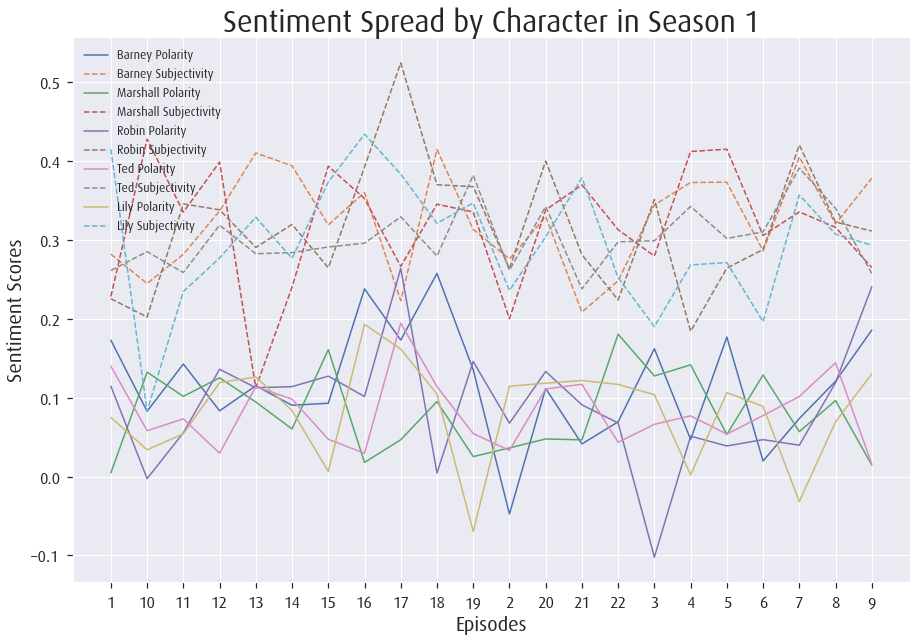

In [58]:
char_set = set(s1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = s1epsent.loc[s1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Sentiment Spread by Character in Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

Okay so looking at just season 1 is telling us a couple of things, first, we need to figure out how to reorganize the episodes, as they are in string format so they are organized by 1s then 2s instead of number order. We also probably don't need to put all of the characters on the same plot. Let's think about some character dynamics that would be interesting to look at:
* Marshall and Lily: They break up at the end of season 1 and get back together throughout season 2, so maybe creating a total season 1-2 sentiment chart of just those two characters would be interesting to look at.
* Ted and Robin: Season 1 is all about Ted chasing Robin, and season 2 is about them getting together, and season 3 is following their breakup, so perhaps looking at the sentiment changes between them across those three seasons would be interesting.
* Barney and Robin: Season 3-5 we start to see the back and forth between Robin and Barney, so a graph looking at their sentiment could be interesting as well.

Let's take a peek at these three, as well as keeping in mind reorganizing the episodes so they're in order.

### Marshall and Lily Sentiment Spread

In [59]:
q5 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Marshall', 'Lily')
GROUP BY Season, Episode, Character
;
""", conn)

q5

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1      Lily      0.074928          0.414778
1        1       1  Marshall      0.004677          0.228136
2        1      10      Lily      0.033862          0.082738
3        1      10  Marshall      0.132308          0.427561
4        1      11      Lily      0.054159          0.234360
..     ...     ...       ...           ...               ...
273      8      18  Marshall      0.000000          0.000000
274      8      24  Marshall      0.250000          0.275000
275      8       5  Marshall      0.000000          0.066667
276      8       7      Lily     -0.262500          0.350000
277      8       7  Marshall      0.000000          0.000000

[278 rows x 5 columns]

In [60]:
mls1epsent = q5[q5['Season'] == '1'] #DF for marsh/lil season 1 sentiments by episode
mls2epsent = q5[q5['Season'] == '2'] #DF for marsh/lil season 2 sentiments by episode

mls1epsent.head()

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0      1       1      Lily      0.074928          0.414778
1      1       1  Marshall      0.004677          0.228136
2      1      10      Lily      0.033862          0.082738
3      1      10  Marshall      0.132308          0.427561
4      1      11      Lily      0.054159          0.234360

In [69]:
mls1epsent['SeEp'] = mls1epsent['Episode'].astype(int)
mls2epsent['SeEp'] = mls2epsent['Episode'].astype(int)

<ipython-input-69-1b09db6991dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mls2epsent['SeEp'] = mls2epsent['Episode'].astype(int)


In [70]:
mls1epsent = mls1epsent.sort_values(by = ['SeEp'], ascending = True)
mls2epsent = mls2epsent.sort_values(by = ['SeEp'], ascending = True)

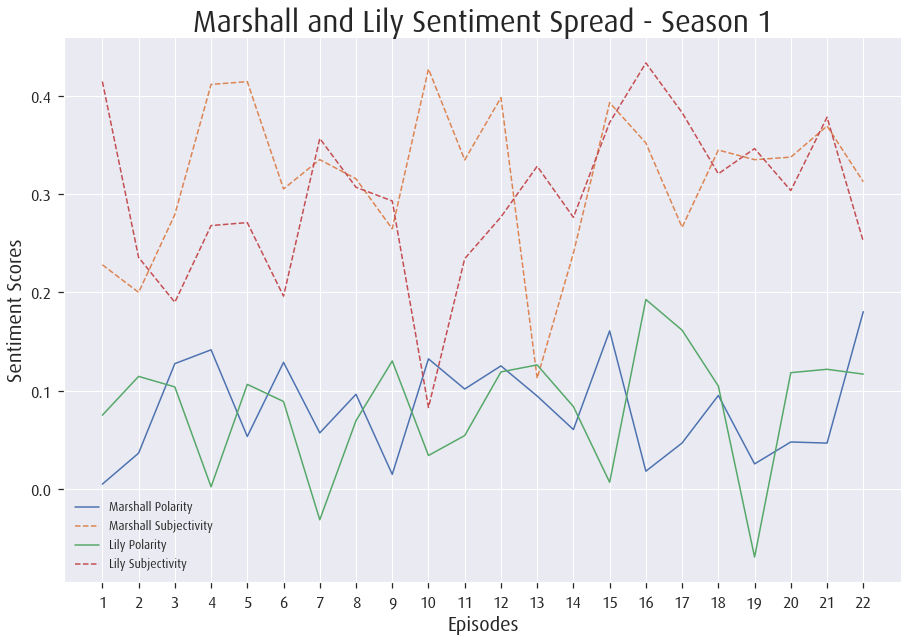

In [74]:
char_set = set(mls1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = mls1epsent.loc[mls1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Marshall and Lily Sentiment Spread - Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

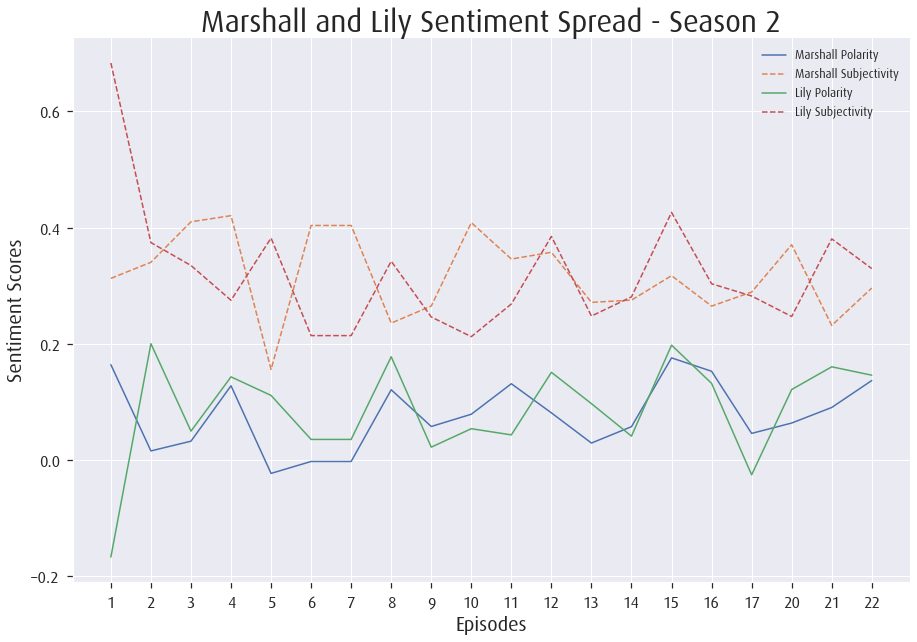

In [75]:
char_set = set(mls2epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = mls2epsent.loc[mls2epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Marshall and Lily Sentiment Spread - Season 2', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

### Ted and Robin Sentiment Spread

In [76]:
q6 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Ted', 'Robin')
GROUP BY Season, Episode, Character
;
""", conn)

q6

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1     Robin      0.114525          0.225241
1        1       1       Ted      0.139807          0.261053
2        1      10     Robin     -0.002587          0.202146
3        1      10       Ted      0.058059          0.284861
4        1      11     Robin      0.055362          0.345430
..     ...     ...       ...           ...               ...
273      8      19       Ted      0.000000          0.000000
274      8      24       Ted      0.800000          1.000000
275      8       7       Ted     -0.033333          0.066667
276      8       9     Robin     -0.140278          0.331944
277      8       9       Ted      0.000000          0.500000

[278 rows x 5 columns]

In [79]:
trs1epsent = q6[q6['Season'] == '1'] #DF for ted/robin season 1 sentiments by episode
trs2epsent = q6[q6['Season'] == '2'] #DF for ted/robin season 2 sentiments by episode
trs3epsent = q6[q6['Season'] == '3'] #DF for ted/robin season 3 sentiments by episode

trs1epsent.head()

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0      1       1     Robin      0.114525          0.225241
1      1       1       Ted      0.139807          0.261053
2      1      10     Robin     -0.002587          0.202146
3      1      10       Ted      0.058059          0.284861
4      1      11     Robin      0.055362          0.345430

In [80]:
trs1epsent['SeEp'] = trs1epsent['Episode'].astype(int)
trs2epsent['SeEp'] = trs2epsent['Episode'].astype(int)
trs3epsent['SeEp'] = trs3epsent['Episode'].astype(int)

<ipython-input-80-33544780bf09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs1epsent['SeEp'] = trs1epsent['Episode'].astype(int)
<ipython-input-80-33544780bf09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs2epsent['SeEp'] = trs2epsent['Episode'].astype(int)
<ipython-input-80-33544780bf09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [81]:
trs1epsent = trs1epsent.sort_values(by = ['SeEp'], ascending = True)
trs2epsent = trs2epsent.sort_values(by = ['SeEp'], ascending = True)
trs3epsent = trs3epsent.sort_values(by = ['SeEp'], ascending = True)

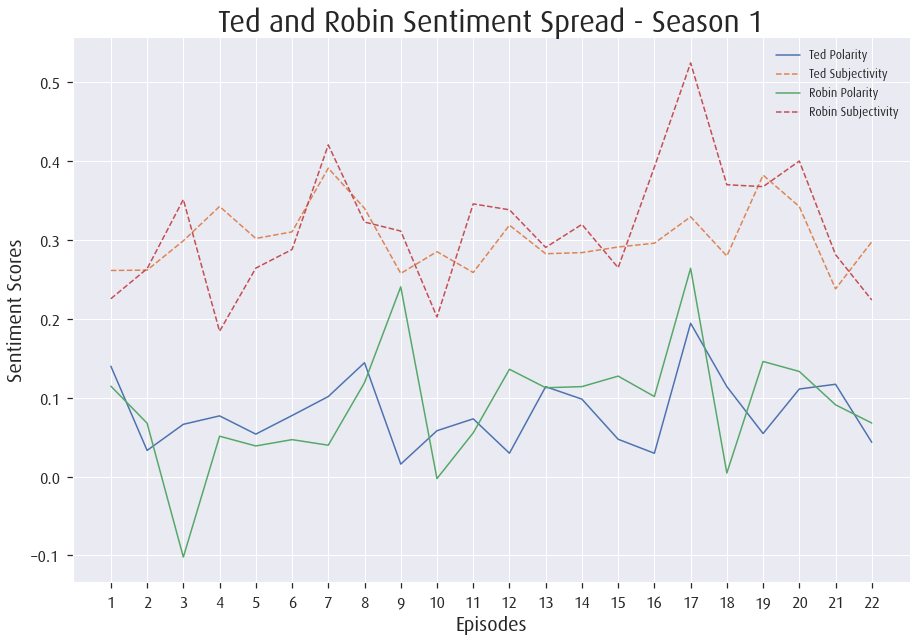

In [82]:
char_set = set(trs1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs1epsent.loc[trs1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

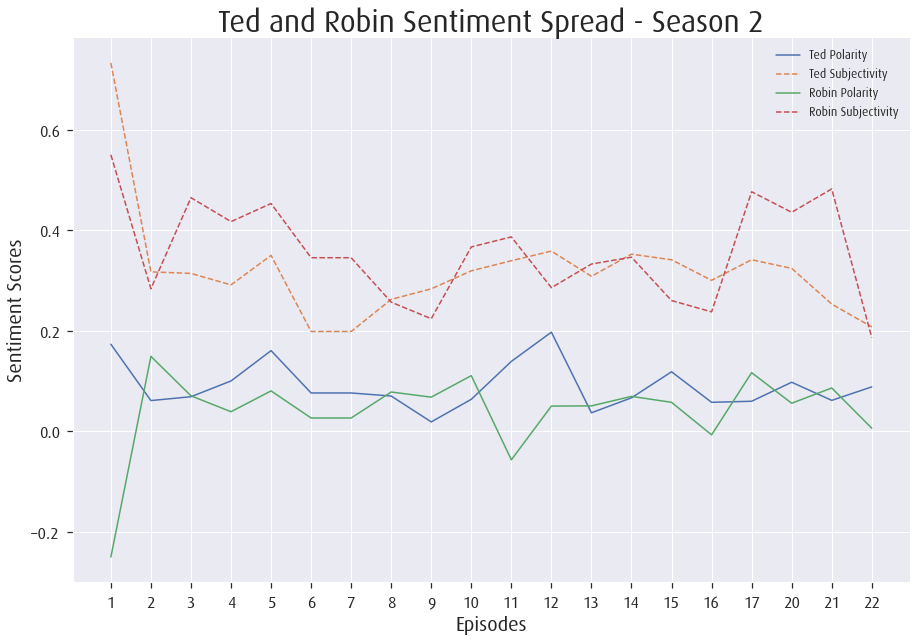

In [83]:
char_set = set(trs2epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs2epsent.loc[trs2epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 2', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

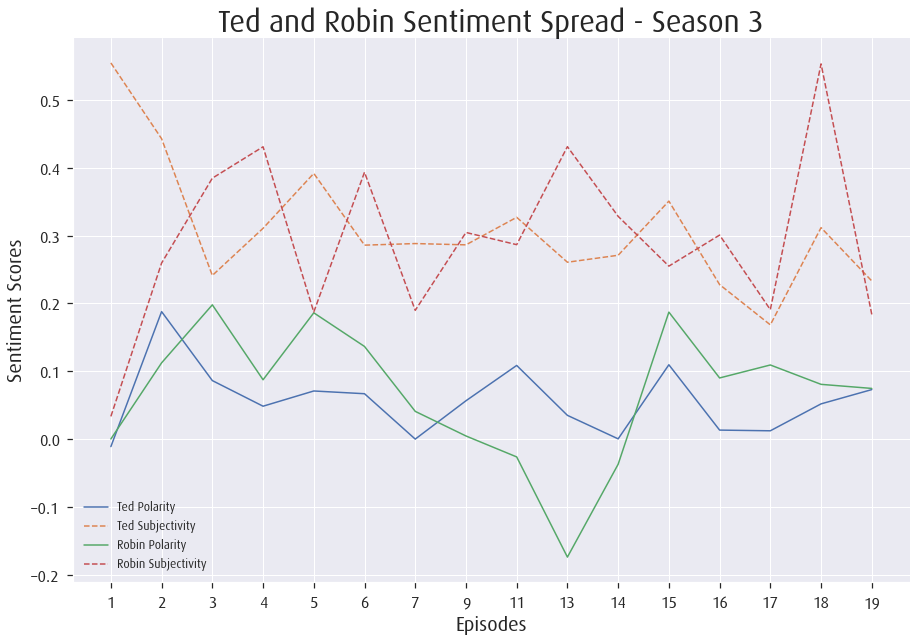

In [84]:
char_set = set(trs3epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs3epsent.loc[trs3epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 3', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

### Barney and Robin Sentiment Spread

In [85]:
q7 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Barney', 'Robin')
GROUP BY Season, Episode, Character
;
""", conn)

q7

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1    Barney      0.172737          0.281741
1        1       1     Robin      0.114525          0.225241
2        1      10    Barney      0.082633          0.244551
3        1      10     Robin     -0.002587          0.202146
4        1      11    Barney      0.142594          0.281614
..     ...     ...       ...           ...               ...
270      8      14     Robin      0.000000          0.000000
271      8      19    Barney      0.000000          0.000000
272      8      22    Barney      0.166667          0.600000
273      8      24    Barney      0.112500          0.209821
274      8       9     Robin     -0.140278          0.331944

[275 rows x 5 columns]

In [88]:
brs3epsent = q7[q7['Season'] == '3'] #DF for ted/robin season 1 sentiments by episode
brs4epsent = q7[q7['Season'] == '4'] #DF for ted/robin season 2 sentiments by episode
brs5epsent = q7[q7['Season'] == '5'] #DF for ted/robin season 3 sentiments by episode

brs3epsent.head()

Season Episode Character  Avg_Polarity  Avg_Subjectivity
84      3       1    Barney      0.104444          0.343472
85      3       1     Robin      0.000000          0.033333
86      3      11    Barney      0.114548          0.255029
87      3      11     Robin     -0.026467          0.286754
88      3      13    Barney      0.093990          0.303437

In [89]:
brs3epsent['SeEp'] = brs3epsent['Episode'].astype(int)
brs4epsent['SeEp'] = brs4epsent['Episode'].astype(int)
brs5epsent['SeEp'] = brs5epsent['Episode'].astype(int)

<ipython-input-89-156327cd1ad2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brs3epsent['SeEp'] = brs3epsent['Episode'].astype(int)
<ipython-input-89-156327cd1ad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brs4epsent['SeEp'] = brs4epsent['Episode'].astype(int)
<ipython-input-89-156327cd1ad2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [90]:
brs3epsent = brs3epsent.sort_values(by = ['SeEp'], ascending = True)
brs4epsent = brs4epsent.sort_values(by = ['SeEp'], ascending = True)
brs5epsent = brs5epsent.sort_values(by = ['SeEp'], ascending = True)

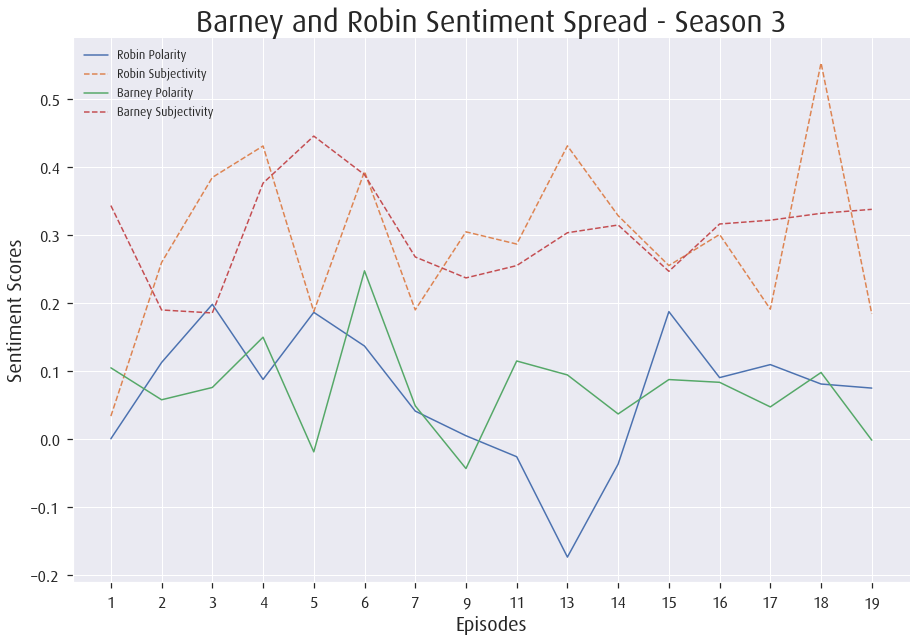

In [91]:
char_set = set(brs3epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs3epsent.loc[brs3epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 3', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

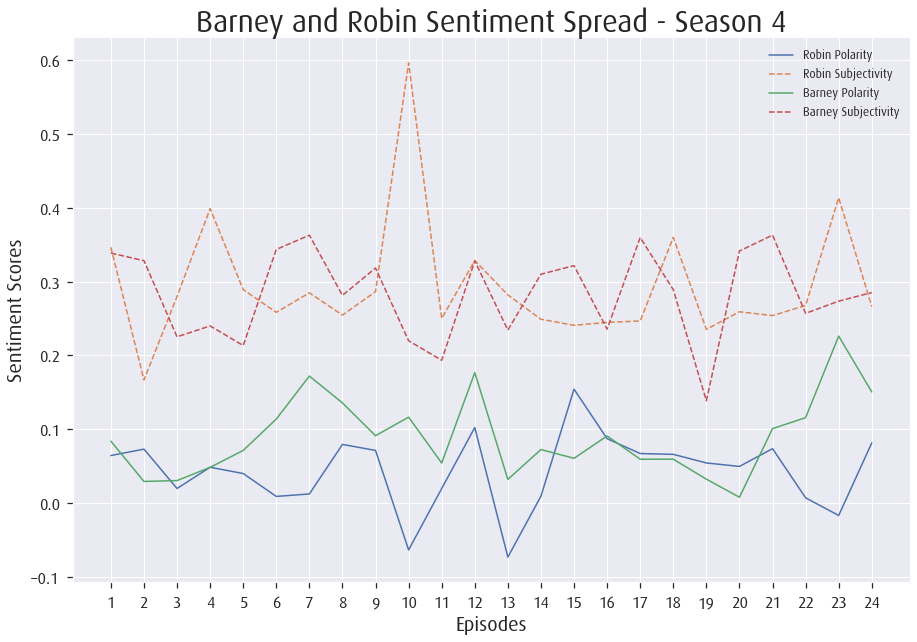

In [92]:
char_set = set(brs4epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs4epsent.loc[brs4epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 4', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

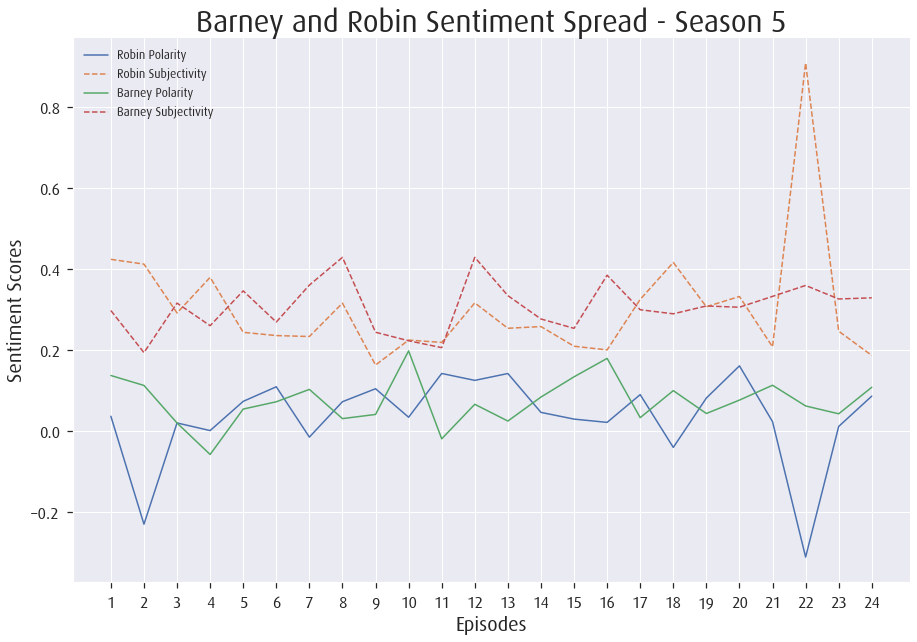

In [93]:
char_set = set(brs5epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs5epsent.loc[brs5epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 5', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

Looking at Barney and Robin specifically gives a great example of how their storylines coincide with the spread of their subjectivity and polarity.

Now that we have sufficiently explored the data, we have enough information to inform us as we move through our modeling process. We'll finish off this notebook by preparing our text data to be modeled in the next notebook.

## Preparing to Model

For our data to be ready to model, we just need a list of tokens for each line, and the character name.

In [94]:
ModelDF = pd.read_sql("""
SELECT Character, Line
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
;
""", conn)

ModelDF

Character                                               Line
0      Marshall                                 Will you marry me.
1           Ted  Yes, perfect! And then you're engaged, you pop...
2      Marshall  Got it. Thanks for helping me plan this out, Ted.
3           Ted  Dude, are you kidding? It's you and Lily! I've...
4      Marshall           yeah, sorry. We thought you were asleep.
...         ...                                                ...
22470  Marshall                                 It is so much fun.
22471  Marshall                               I love crushed nuts.
22472    Barney  "I'm probably saying some political stuff righ...
22473    Barney                Whoa. Is there going to be a fight?
22474       Ted                                     They're happy.

[22475 rows x 2 columns]

In [95]:
ModelDF.Line = ModelDF.Line.apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x)) #Removing all non alphabet characters

ModelDF.Line = ModelDF.Line.str.lower() #Making everything lowercase

ModelDF #Checking ModelDF

Character                                               Line
0      Marshall                                  will you marry me
1           Ted  yes perfect and then youre engaged you pop the...
2      Marshall     got it thanks for helping me plan this out ted
3           Ted  dude are you kidding its you and lily ive been...
4      Marshall              yeah sorry we thought you were asleep
...         ...                                                ...
22470  Marshall                                  it is so much fun
22471  Marshall                                i love crushed nuts
22472    Barney  im probably saying some political stuff right ...
22473    Barney                  whoa is there going to be a fight
22474       Ted                                       theyre happy

[22475 rows x 2 columns]

In [97]:
ModelDF['Tokens'] = ModelDF.Line.apply(lambda x: remstopandtok(x)) #Applying function to build new column

ModelDF.head() #Reviewing df to make sure column was added

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

In [99]:
ModelDF.to_csv('ModelDF.csv', index = False) #Saving df to csv for modeling

Now it's time to move to the next notebook and build a model to predict which character said which line!